In [255]:
!pip install ydata-profiling
# !pip install xgboost

DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/python_docx-1.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /Users/mac/anaconda3/lib/python3.11/site-packages/Pattern-3.6.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [256]:
# TODO: add the scrapper here

In [475]:
import re
import string
from typing import List

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from ydata_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [258]:
"""
This Clas handles the text in the dataset
- it's used to a manipulate textual data
"""


class TextWrangler:
    def __init__(self):
        self.count = CountVectorizer()
        self.tf_idf_ = TfidfVectorizer()
        self.spacy_en = spacy.load('en_core_web_sm')
        # Download stopwords if not already downloaded
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            import nltk
            nltk.download('stopwords')
            nltk.download('punkt')
            self.stop_words = set(stopwords.words('english'))

    @staticmethod
    def remove_digit(text: str) -> str:
        """
        This method removes digit from a text
        """
        return re.sub(r'\d+', '', text)

    @staticmethod
    def remove_punctuations(text: str) -> str:
        """
        This method removes punctuation from a text
        """
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def clean_text(text: str) -> str:
        """
        Clean the text and remove punctuations.
        """
        text = re.sub('<.*?>', '', text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        return text.lower()

    @staticmethod
    def word_lengthening(text: str) -> str:
        """
        Fix a word by reducing any character repeated three or more times
        to just two instances of that character.
        """
        return re.sub(r'(.)\1{2,}', r'\1\1', text.strip())

    @staticmethod
    def tokenize(text: str) -> List[str]:
        """
        Tokenize the given text into words.
        """
        return word_tokenize(text)

    def remove_stopwords(self, text: str) -> str:
        """
        Remove stop words from a given text.
        """
        filtered_text = [word for word in self.tokenize(text) if word.lower() not in self.stop_words]
        return ' '.join(filtered_text)

    def lemmatizer(self, text: str) -> str:
        """
        This method lemmatize a text by using the spaCy libary
        """
        text = self.spacy_en(text)

        # get the lemmatized token from text
        lemmatized_tokens = [token.lemma_ for token in text]

        # use lemmatized token to form a sentence
        return ' '.join(lemmatized_tokens)

    def init_bag_of_words(self, end_range: int):
        """
        This method initialize Bag of Words with n_gram end range which can be 1, 2 or 3
        """
        self.count = CountVectorizer(ngram_range=(1, end_range))
        return self.count

    def bag_of_words(self, text: List[str]):
        """
        Compute the Bag of Words matrix for the given list of texts.
        """
        return self.count.fit_transform(text)

    def init_tf_idf(self, end_range: int):
        """
        This method initialize TF-IDF with n_gram end range which can be 1, 2 or 3
        """
        self.tf_idf_ = TfidfVectorizer(ngram_range=(1, end_range))
        return self.tf_idf_

    def tf_idf(self, text: List[str]):
        """
        Compute the TF-IDF matrix for the given list of texts.
        """
        return self.tf_idf_.fit_transform(text)

    @staticmethod
    def plot_word_cloud(data, title):
        """
        Generate a graphical representation of the words in the text
        """
        wordcloud = WordCloud(width=900, height=600, max_words=100, background_color='white').generate(data)

        plt.figure(figsize=(20, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=15)
        plt.axis('off')
        plt.show()
        return

In [259]:
text_wrangler = TextWrangler()

In [260]:
"""
TextSentimentAnalysis Class provides the sentiment for the input text in its raw form
"""


class TextSentimentAnalysis:
    def __init__(self) -> None:
        """
        Initialize vader sentiment analyzer
        """
        self.sid = SentimentIntensityAnalyzer()

    def get_sentiment_via_vader(self, text: str) -> float:
        """
        return the compound score
        """
        # Using compound score as a single sentiment score
        return self.sid.polarity_scores(text)['compound']

In [261]:
text_sentiment_analysis = TextSentimentAnalysis()

#### Project Setup and Data Collection: ✅

1) Set up your Jupyter notebook ✅
2) Scrape or pull data from online resources ✅
3) Load the data into your notebook ✅ <br /><br />


In [262]:
# Load the dataset into your notebook 

df = pd.read_csv(
    'dataset.csv',
    index_col=0,
)

In [263]:
df.columns

Index(['Movie ID', 'Title', 'IMDB Rating', 'Directors', 'Writers', 'Stars',
       'Storyline', 'Origin Countries', 'Languages', 'Budget',
       'Gross Worldwide', 'Runtime', 'Genres'],
      dtype='object')

In [264]:
df.rename(columns={
    'Movie ID': 'id',
    'Title': 'title',
    'IMDB Rating': 'rating',
    'Directors': 'directors',
    'Writers': 'writers',
    'Stars': 'stars',
    'Storyline': 'storyline',
    'Origin Countries': 'origin_countries',
    'Languages': 'languages',
    'Budget': 'budget',
    'Gross Worldwide': 'revenue',
    'Runtime': 'runtime',
    'Genres': 'genres'
}, inplace=True)

In [265]:
df.head()

,id,title,rating,directors,writers,stars,storyline,origin_countries,languages,budget,revenue,runtime,genres
0,tt0060437,Funeral in Berlin,6.8,​Guy Hamilton,"​Len Deighton, ​Evan Jones",", ​Michael Caine, ​Oscar Homolka, ​Paul Hubsch...",Sent to East Berlin to retrieve a Communist de...,United Kingdom,"English, German",NaN,$183,1 hour 42 minutes,Thriller
1,tt0098300,Shag,NaN,​Zelda Barron,", ​Lanier Laney, ​Terry Sweeney, ​Robin Swicord,",", ​Phoebe Cates, ​Bridget Fonda, ​Scott Coffey,",Summer of 1963. Carson is getting married to h...,"United States, United Kingdom",English,"$5,000,000 (estimated)","$6,957,975",1 hour 38 minutes,"Comedy, Drama, Romance"
2,tt1853739,You're Next,6.6,​Adam Wingard,​Simon Barrett,", ​Sharni Vinson, ​Joe Swanberg, ​AJ Bowen,",When the Davison family comes under attack dur...,"United States, United Kingdom",English,"$1,000,000 (estimated)","$26,895,481",1 hour 35 minutes,"Drama, Horror, Thriller"
3,tt22036900,Covid Karma,NaN,​Biju Viswanath,"noneStars, ​Rodney Norman, ​Christine Ohlman, ...",​Biju Viswanath,An Indian film maker is stuck in USA for five ...,United States,English,NaN,NaN,1 hour 1 minute,"Biography, Comedy"
4,tt0419434,American Hardcore,NaN,​Paul Rachman,"noneWriter, ​Steven Blush, noneWriter",", ​Greg Ginn, ​Ian MacKaye, ​James Drescher,",The History of American Punk Rock 1980-1986,United States,English,NaN,"$376,057",1 hour 40 minutes,"Documentary, History, Music"


In [266]:
# Conversion rates dictionary
exchange_rates = {
    '$': 1.0,  # USD to USD (base currency)
    '€': 1.13,  # EUR to USD
    'FRF\xa0': 0.18,  # FRF to USD (Note: FRF is the French Franc, not in use anymore)
    '£': 1.41  # GBP to USD
}

In [267]:
# This function is to convert all the currencies to USD for gross_worldwide feature
def convert_revenue_to_usd(amount):
    if isinstance(amount, str):
        if amount.startswith('$'):
            # Remove currency symbol
            amount = amount[1:]
            # Remove commas  
            amount = amount.replace(',', '')
            # Converting to float 
            return float(amount)
        elif amount.startswith('€'):
            amount = amount[1:]
            amount = amount.replace(',', '')
            amount = float(amount)
            return amount * exchange_rates['€']
        elif amount.startswith('FRF\xa0'):
            amount = amount[4:]
            amount = amount.replace(',', '')
            amount = float(amount)
            return amount * exchange_rates['FRF\xa0']
        elif amount.startswith('£'):
            amount = amount[1:]
            amount = amount.replace(',', '')
            amount = float(amount)
            return amount * exchange_rates['£']
            # Return None if the currency is not supported
        else:
            return None
            # Return None if the currency is not string
    else:
        return None

In [268]:
# Function to convert to USD
def convert_budget_to_usd(amount):
    if isinstance(amount, str):
        # Remove any non-numeric characters (except currency symbols, periods, and commas)
        amount_cleaned = re.sub(r'[^\d\.,€$£FRF\xa0]', '', amount)

        if amount_cleaned.startswith('$'):
            return float(amount_cleaned[1:].replace(',', ''))  # Remove '$' and commas, convert to float
        elif amount_cleaned.startswith('€'):
            return float(amount_cleaned[1:].replace(',', '')) * exchange_rates['€']
        elif amount_cleaned.startswith('FRF\xa0'):
            return float(amount_cleaned[4:].replace(',', '')) * exchange_rates['FRF\xa0']
        elif amount_cleaned.startswith('£'):
            return float(amount_cleaned[1:].replace(',', '')) * exchange_rates['£']
        else:
            return None  # Return None for unsupported currencies
    else:
        return None  # Return None for non-string types

In [269]:
def convert_runtime_to_minutes(runtime):
    if 'hour' in runtime and 'minute' in runtime:
        try:
            hours, minutes = runtime.split(' hour ')
            minutes = minutes.replace(' minutes', '')
            total_minutes = int(hours) * 60 + int(minutes)
        except ValueError:
            total_minutes = 0
    elif 'hour' in runtime:
        try:
            hours = runtime.replace(' hours', '').replace(' hour', '')
            total_minutes = int(hours) * 60
        except ValueError:
            total_minutes = 0
    elif 'minute' in runtime:
        try:
            minutes = runtime.replace(' minutes', '')
            total_minutes = int(minutes)
        except ValueError:
            total_minutes = 0
    else:
        total_minutes = 0  # Handle unexpected cases gracefully

    return total_minutes

In [270]:
df['revenue_in_usd'] = df['revenue'].apply(convert_revenue_to_usd)

df['revenue_in_usd'].head()

0         183.0
1     6957975.0
2    26895481.0
3           NaN
4      376057.0
Name: revenue_in_usd, dtype: float64

In [271]:
df['budget_in_usd'] = df['budget'].apply(convert_budget_to_usd)

df['budget_in_usd'].head()

0          NaN
1    5000000.0
2    1000000.0
3          NaN
4          NaN
Name: budget_in_usd, dtype: float64

In [272]:
df['runtime'].fillna('', inplace=True)

# Apply the function to convert runtime to minutes
df['runtime_in_minutes'] = df['runtime'].apply(convert_runtime_to_minutes)

df['runtime_in_minutes'].head()

0    102
1     98
2     95
3      0
4    100
Name: runtime_in_minutes, dtype: int64

2. Exploratory Data Analysis (EDA):
    - 2.1 Initial data inspection (shape, info, describe)  ✅
    - 2.2 Generate and save pandas profiling report  ✅
    - 2.3 Visualize data distributions ('IMDB Rating', 'Budget', 'Gross Worldwide', 'Runtime')  ✅
    - 2.4 Explore relationships between 'Gross Worldwide' and other variables  ✅
    - 2.5 Analyze categorical data ('Directors', 'Writers', 'Stars', 'Origin Countries', 'Languages', 'Genres')  ✅
    - 2.6 Identify potential issues (missing values, duplicates)<br /><br />


#### 2.1 Initial data inspection (shape, info, describe)

In [273]:
df.shape

(46646, 16)

we've 13 columns (features) and 46,646 rows in this dataset

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46646 entries, 0 to 46645
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  46646 non-null  object 
 1   title               46573 non-null  object 
 2   rating              24971 non-null  float64
 3   directors           43308 non-null  object 
 4   writers             43308 non-null  object 
 5   stars               43308 non-null  object 
 6   storyline           42363 non-null  object 
 7   origin_countries    44661 non-null  object 
 8   languages           43435 non-null  object 
 9   budget              14748 non-null  object 
 10  revenue             17622 non-null  object 
 11  runtime             46646 non-null  object 
 12  genres              46572 non-null  object 
 13  revenue_in_usd      17593 non-null  float64
 14  budget_in_usd       13472 non-null  float64
 15  runtime_in_minutes  46646 non-null  int64  
dtypes: float6

In [275]:
df.describe()

,rating,revenue_in_usd,budget_in_usd,runtime_in_minutes
count,24971.000000,1.759300e+04,1.347200e+04,46646.000000
mean,6.135405,3.974123e+07,1.944457e+07,71.450542
std,1.223421,1.231753e+08,3.911374e+07,417.610945
min,1.000000,3.000000e+00,1.000000e+00,0.000000
25%,5.400000,1.740360e+05,1.000000e+06,0.000000
50%,6.300000,2.443487e+06,5.500000e+06,87.000000
75%,7.000000,2.222751e+07,2.000000e+07,98.000000
max,10.000000,2.923706e+09,2.000000e+09,59460.000000


In [276]:
# 2.2 Generate and save pandas profiling report
profile = ProfileReport(df, title="Movie Report")
profile.to_file('movie_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [277]:
df.head()

,id,title,rating,directors,writers,stars,storyline,origin_countries,languages,budget,revenue,runtime,genres,revenue_in_usd,budget_in_usd,runtime_in_minutes
0,tt0060437,Funeral in Berlin,6.8,​Guy Hamilton,"​Len Deighton, ​Evan Jones",", ​Michael Caine, ​Oscar Homolka, ​Paul Hubsch...",Sent to East Berlin to retrieve a Communist de...,United Kingdom,"English, German",NaN,$183,1 hour 42 minutes,Thriller,183.0,NaN,102
1,tt0098300,Shag,NaN,​Zelda Barron,", ​Lanier Laney, ​Terry Sweeney, ​Robin Swicord,",", ​Phoebe Cates, ​Bridget Fonda, ​Scott Coffey,",Summer of 1963. Carson is getting married to h...,"United States, United Kingdom",English,"$5,000,000 (estimated)","$6,957,975",1 hour 38 minutes,"Comedy, Drama, Romance",6957975.0,5000000.0,98
2,tt1853739,You're Next,6.6,​Adam Wingard,​Simon Barrett,", ​Sharni Vinson, ​Joe Swanberg, ​AJ Bowen,",When the Davison family comes under attack dur...,"United States, United Kingdom",English,"$1,000,000 (estimated)","$26,895,481",1 hour 35 minutes,"Drama, Horror, Thriller",26895481.0,1000000.0,95
3,tt22036900,Covid Karma,NaN,​Biju Viswanath,"noneStars, ​Rodney Norman, ​Christine Ohlman, ...",​Biju Viswanath,An Indian film maker is stuck in USA for five ...,United States,English,NaN,NaN,1 hour 1 minute,"Biography, Comedy",NaN,NaN,0
4,tt0419434,American Hardcore,NaN,​Paul Rachman,"noneWriter, ​Steven Blush, noneWriter",", ​Greg Ginn, ​Ian MacKaye, ​James Drescher,",The History of American Punk Rock 1980-1986,United States,English,NaN,"$376,057",1 hour 40 minutes,"Documentary, History, Music",376057.0,NaN,100


#### 2.3 Visualize distributions of numerical columns

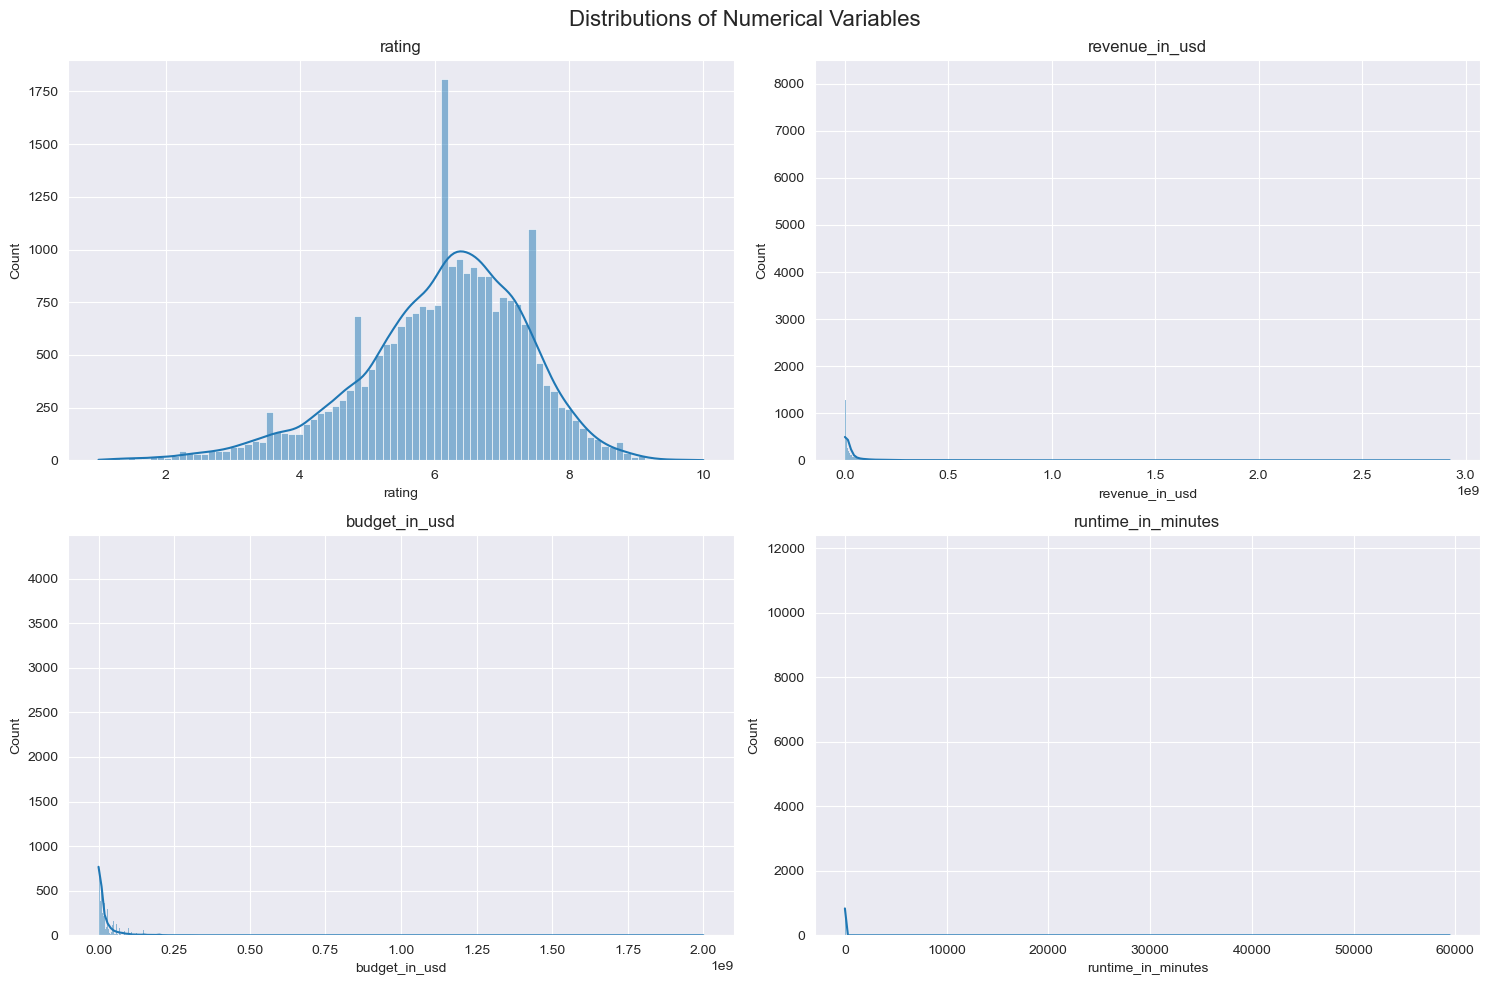

In [278]:
# select all numerical columns
numerical_cols = ['rating', 'revenue_in_usd', 'budget_in_usd', 'runtime_in_minutes']
# TODO:
# numerical_cols = df.select_dtypes(include='number')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distributions of Numerical Variables', fontsize=16)

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(col)

plt.tight_layout()
plt.show()

In [279]:
for column in numerical_cols:
    correlation = df[[column, 'revenue_in_usd']].dropna().corr().iloc[0, 1]
    print(f"Correlation between '{column.replace('_', ' ')}' and 'revenue': {correlation:.2f}")

Correlation between 'rating' and 'revenue': 0.17
Correlation between 'revenue in usd' and 'revenue': 1.00
Correlation between 'budget in usd' and 'revenue': 0.72
Correlation between 'runtime in minutes' and 'revenue': -0.13


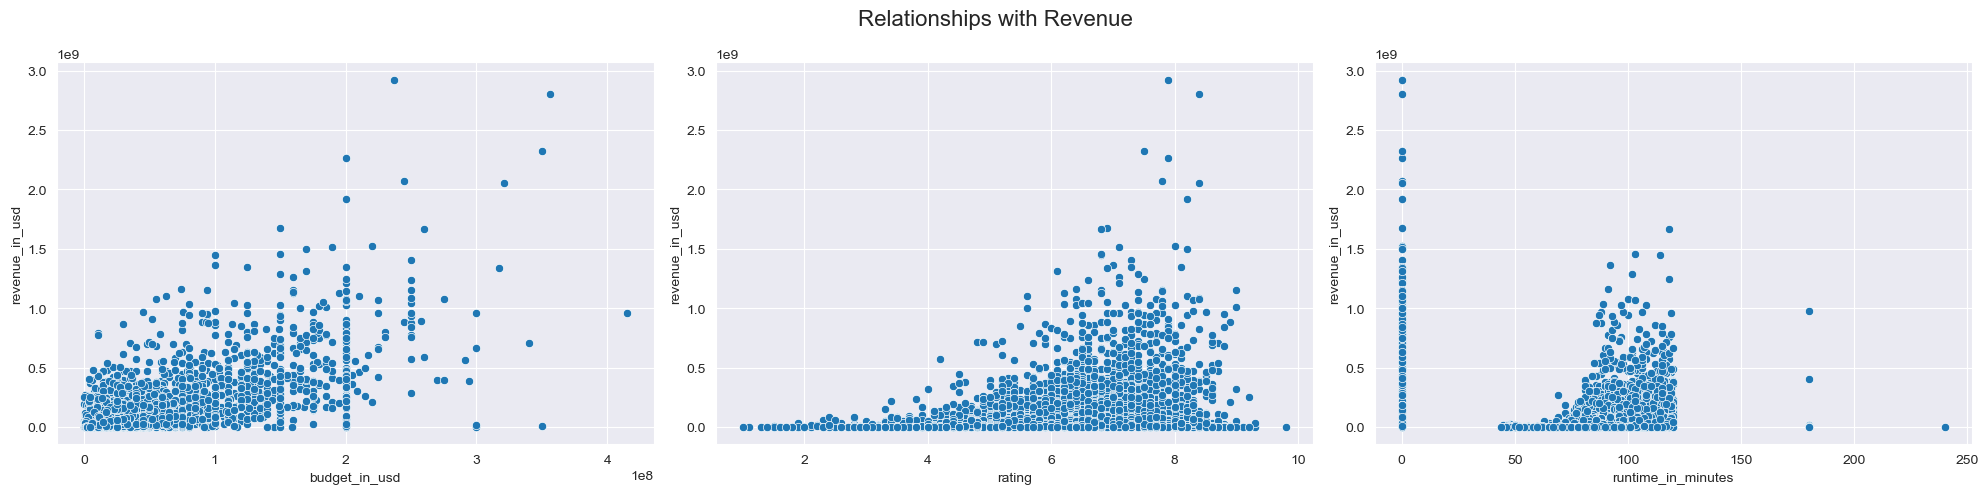

In [280]:
# 2.4 Explore relationships between 'revenue_in_usd' and other numerical variables
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Relationships with Revenue', fontsize=16)

sns.scatterplot(data=df, x='budget_in_usd', y='revenue_in_usd', ax=axes[0])
sns.scatterplot(data=df, x='rating', y='revenue_in_usd', ax=axes[1])
sns.scatterplot(data=df, x='runtime_in_minutes', y='revenue_in_usd', ax=axes[2])

plt.tight_layout()
plt.show()

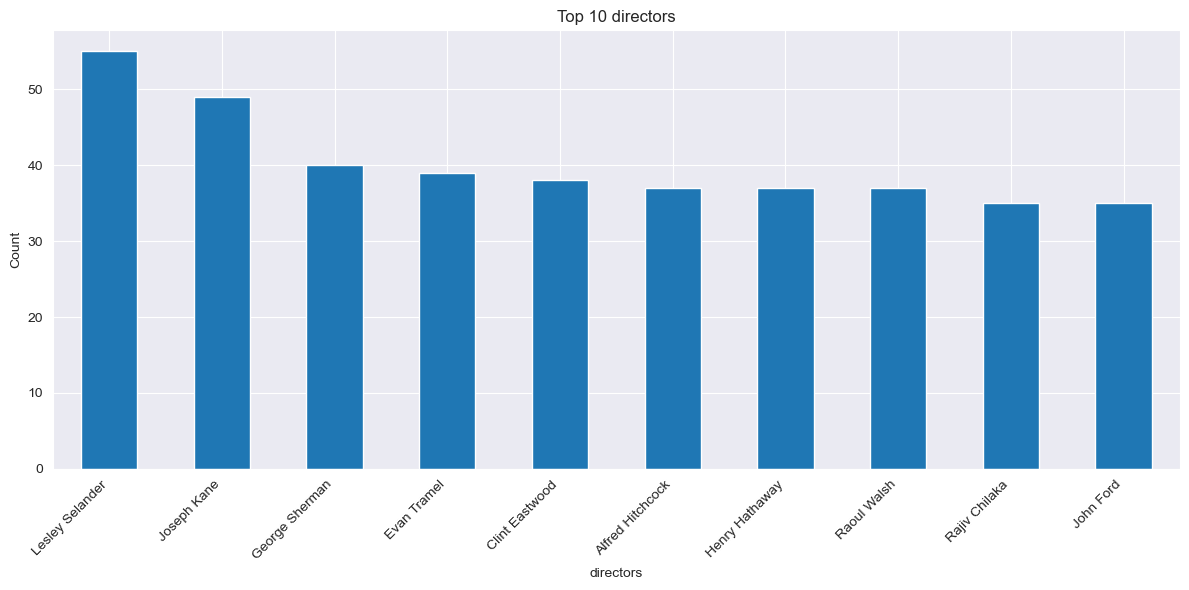

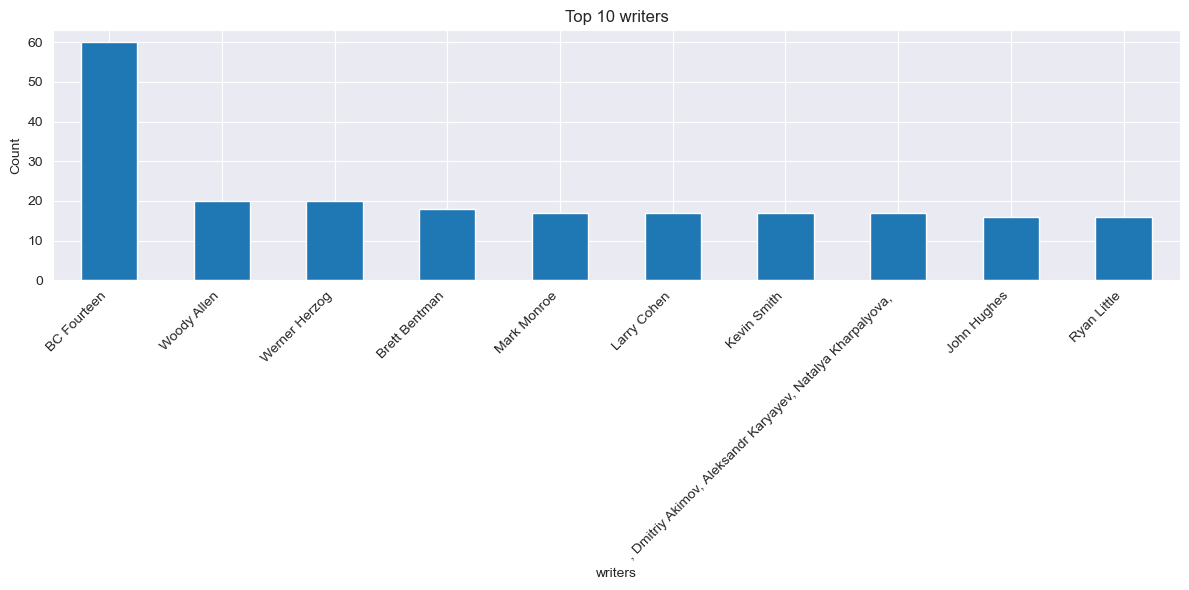

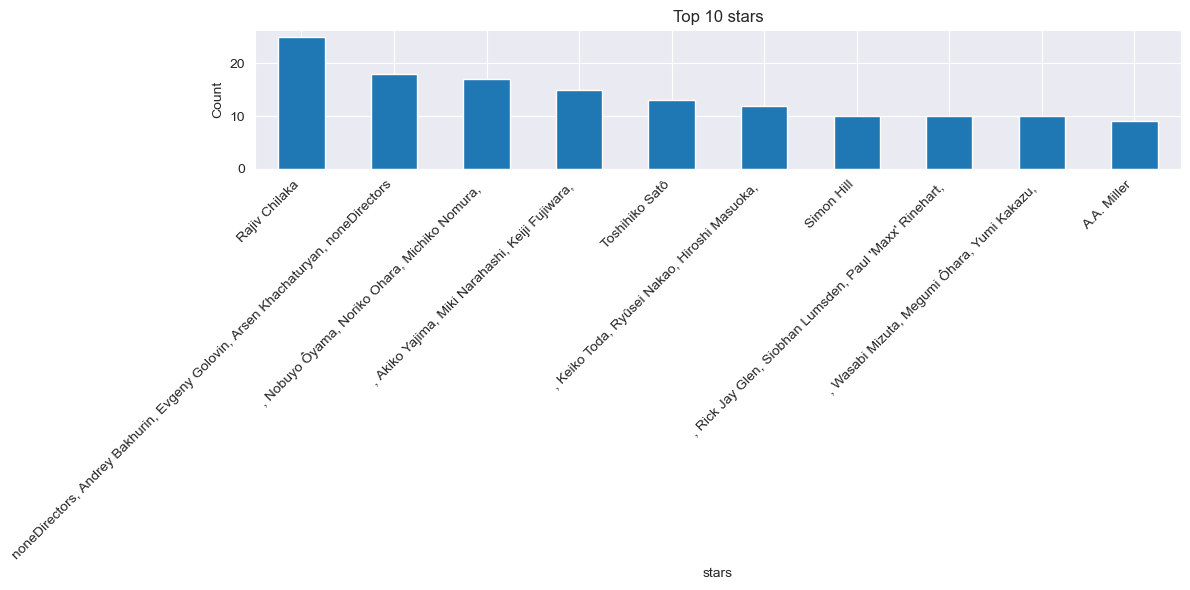

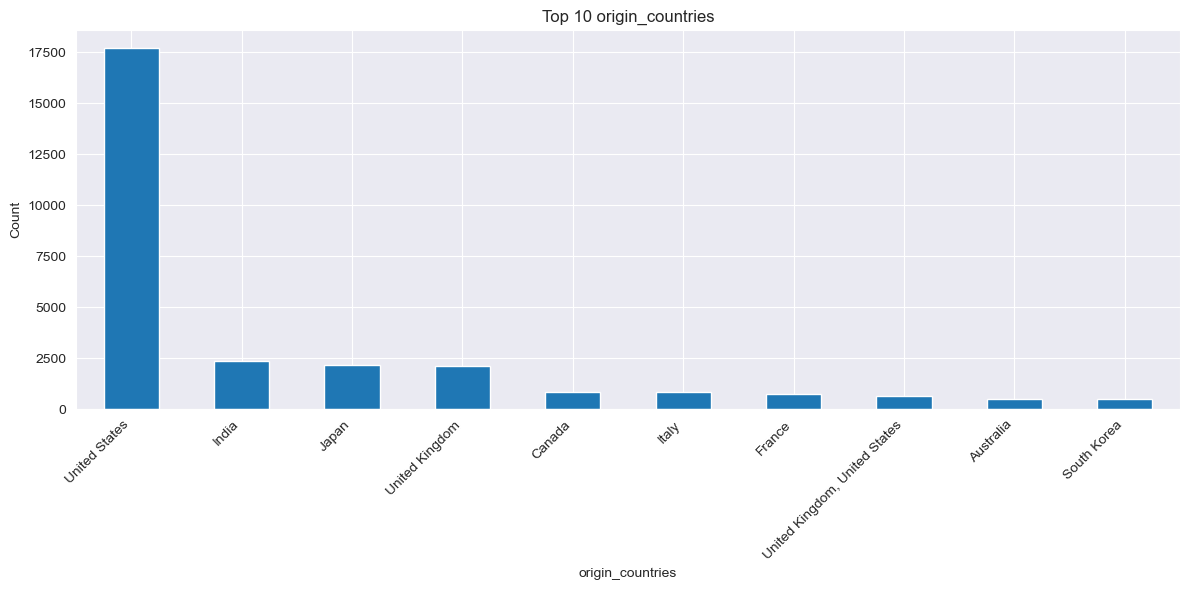

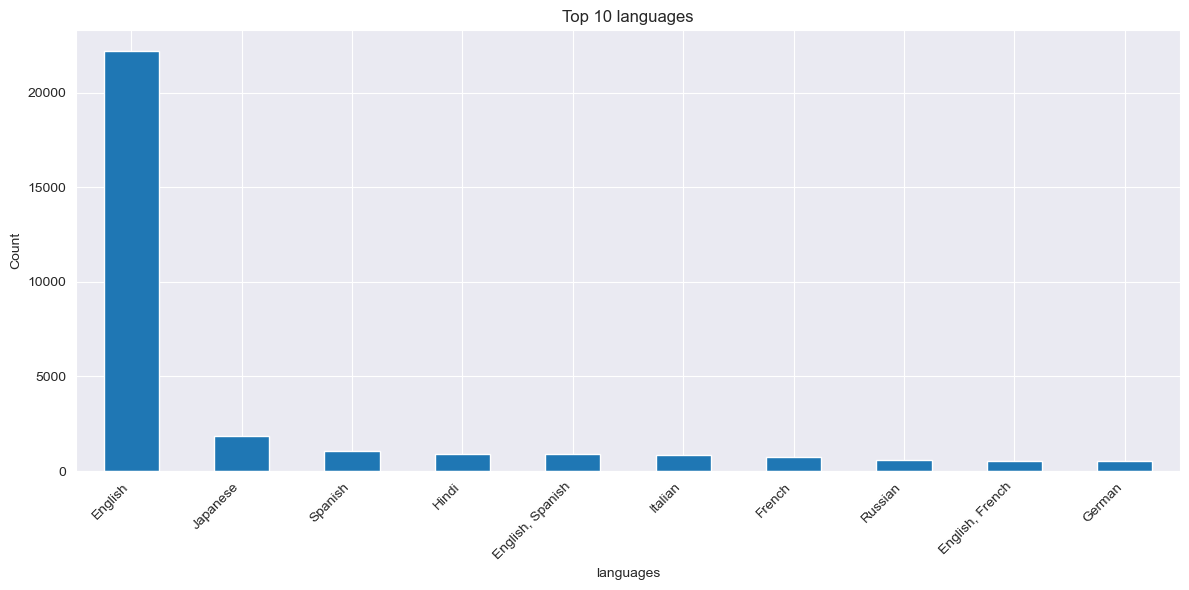

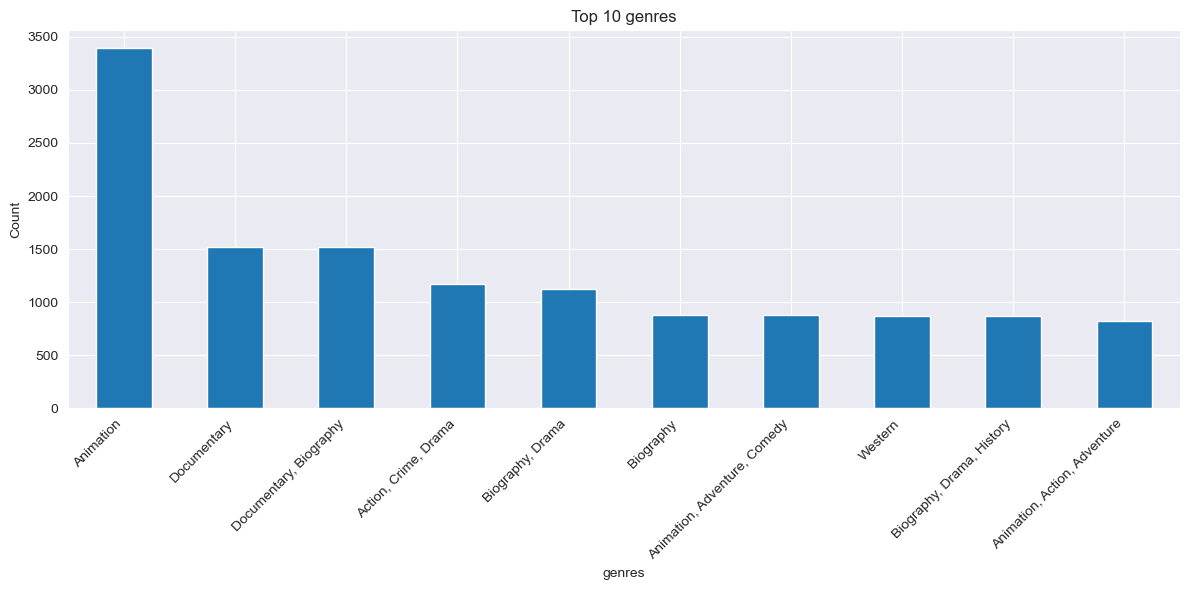

In [281]:
# 2.5 Analyze categorical data
categorical_cols = ['directors', 'writers', 'stars', 'origin_countries', 'languages', 'genres']

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    df[col].dropna().value_counts().nlargest(10).plot(kind='bar')
    plt.title(f'Top 10 {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [427]:
def generate_correlation_heatmap(_df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(_df[numerical_cols].dropna().corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    # sns.heatmap(_df.select_dtypes(include='number').dropna().corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Numerical Variables')
    plt.tight_layout()
    plt.show()

In [423]:
generate_correlation_heatmap(_df=df)

KeyError: "['budget_in_usd_log', 'revenue_in_usd_log'] not in index"

<Figure size 1000x800 with 0 Axes>

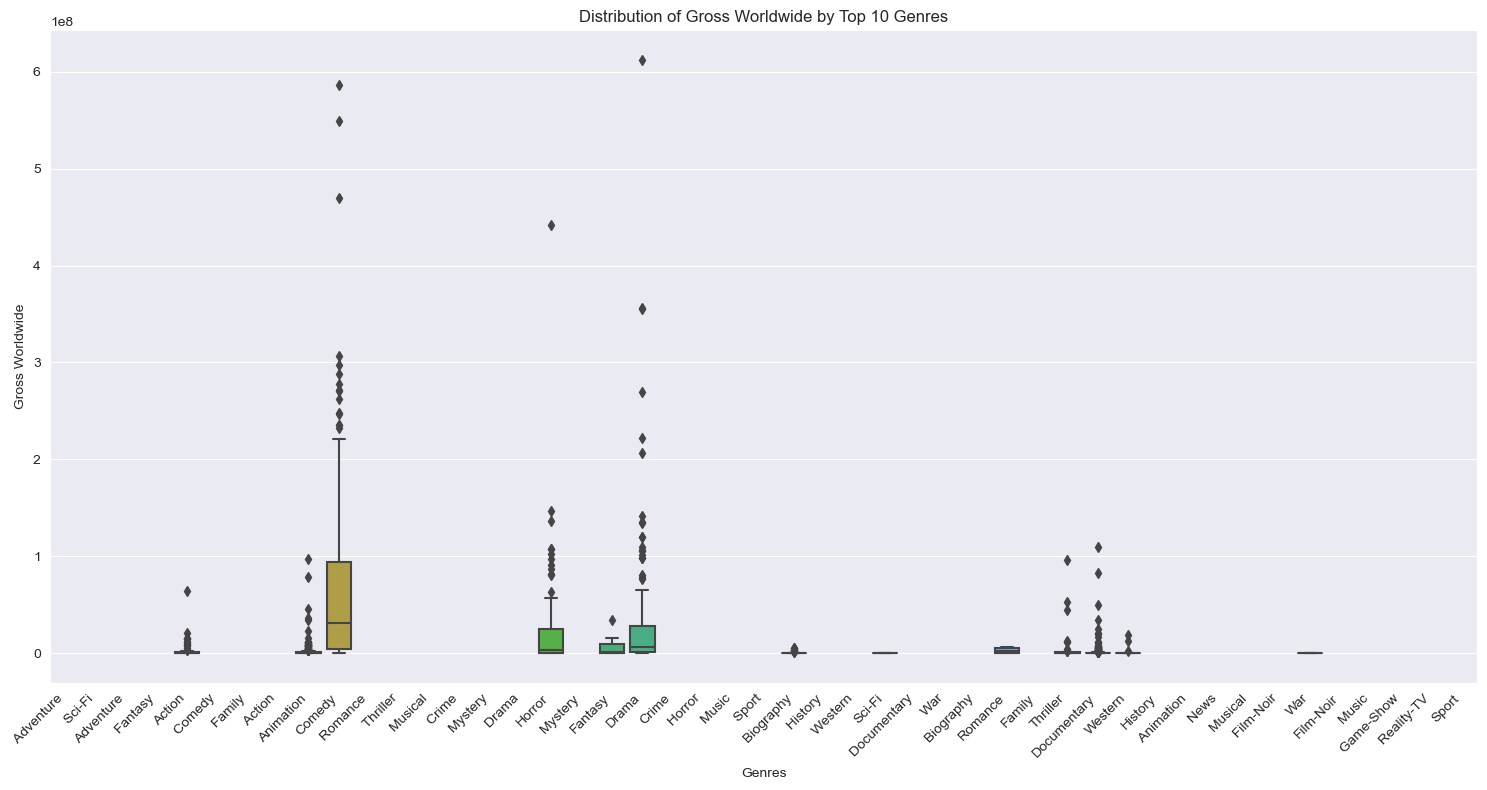

genres_split
 Adventure    1.117132e+08
 Sci-Fi       9.853647e+07
Adventure     8.142273e+07
 Fantasy      7.085559e+07
Action        6.698900e+07
 Comedy       6.213081e+07
 Family       5.419794e+07
 Action       4.710931e+07
Animation     4.440015e+07
Comedy        4.388722e+07
Name: revenue_in_usd, dtype: float64 47


In [284]:
# Box plot for 'Gross Worldwide' by 'genres'

# First, let's split the 'genres' column if it contains multiple genres per movie
df['genres_split'] = df['genres'].str.split(',')

# Explode the 'genres' column so each genre gets its own row
df_exploded = df.explode('genres_split')

# Calculate average `revenue in usd` for each genre
genre_avg = df_exploded.groupby('genres_split')['revenue_in_usd'].mean().sort_values(ascending=False)

# Get all genres
all_genres = genre_avg.head(48).index.tolist()

# Filter the dataframe to include all genres
df_top_10 = df_exploded[df_exploded['genres_split'].isin(all_genres)]

# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='genres', y='revenue_in_usd', data=df_top_10, order=all_genres)
plt.title('Distribution of Gross Worldwide by Top 10 Genres')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Gross Worldwide')
plt.xlabel('Genres')
plt.tight_layout()
plt.show()

# Print average Gross Worldwide for these top 10 genres
print(genre_avg.head(10), len(genre_avg))

3. Data Cleaning and Preprocessing:
    - 3.1 Handle missing values
    - 3.2 Remove duplicates
    - 3.3 Correct data types (ensure 'Budget' and 'Gross Worldwide', 'Runtime', etc. are numerical)
    - 3.4 Handle outliers:
        - 3.4.1 Detect outliers (boxplots and IQR)
        - 3.4.2 Apply treatment methods:
            - Quantile-based Flooring and Capping
            - Trimming
            - Log Transformation
    - 3.5 Compare and discuss outcomes of outlier treatments<br /><br />

#### 3.1 Handle Missing Values

In [285]:
# average percentage of missing values of all features
df.isna().mean() * 100

id                     0.000000
title                  0.156498
rating                46.467007
directors              7.156026
writers                7.156026
stars                  7.156026
storyline              9.181923
origin_countries       4.255456
languages              6.883763
budget                68.383141
revenue               62.221841
runtime                0.000000
genres                 0.158642
revenue_in_usd        62.284011
budget_in_usd         71.118638
runtime_in_minutes     0.000000
genres_split           0.158642
dtype: float64

##### Handling missing values for rating

In [286]:
# using KNNImputer to handle missing values of rating

rating_imputer = KNNImputer(n_neighbors=4)
df['rating'] = rating_imputer.fit_transform(np.reshape(df['rating'], (-1, 1)))

df['rating'].isna().mean() * 100

0.0

In [287]:
# average percentage of missing values of all features
df.isna().mean() * 100

id                     0.000000
title                  0.156498
rating                 0.000000
directors              7.156026
writers                7.156026
stars                  7.156026
storyline              9.181923
origin_countries       4.255456
languages              6.883763
budget                68.383141
revenue               62.221841
runtime                0.000000
genres                 0.158642
revenue_in_usd        62.284011
budget_in_usd         71.118638
runtime_in_minutes     0.000000
genres_split           0.158642
dtype: float64

##### Handling missing values for 

We will be handling the missing values by creating a new categorical feature <br />

NOTE: 'None' directors indicate that there are other directors on the movie production, 
who are not in the top 3 listed. <br />
It does not mean zero directors.

In [288]:
# function to transform text into a list of words

def transform_cells(input_string):
    # Step 1: Define patterns to remove
    patterns = [
        r'none(?:Directors|Writers|Stars|Writer)',  # Matches noneDirectors, noneWriters, noneStars, noneWriter
        r'\u200b',  # Matches zero-width space
    ]

    # Step 2: Replace defined patterns with an empty string
    for pattern in patterns:
        input_string = re.sub(pattern, '', input_string)

    # Step 3: Split the string into a list based on ","
    transformed = re.split(r',\s*', input_string.strip(', '))

    return transformed


In [289]:
def categorize_column(column_name: str) -> List[str]:
    categories = []  # Empty list to store transformed records

    for data in df[column_name]:
        # Check if record has a null value
        if pd.isnull(data):
            # Fill with 'not reported' if null
            categories.append('not reported')
        else:
            if len(transform_cells(data)) < 3:
                categories.append('small')
            else:
                categories.append('large')

    return categories

In [290]:
# to handle missing values, a new categorical feature will be created called director team

# create new 'director_team' feature
df['director_team'] = categorize_column('directors')

# preview the distribution
df['director_team'].value_counts()

director_team
small           42185
not reported     3338
large            1123
Name: count, dtype: int64

##### Writer Feature - Handling missing values by creating a new categorical feature

In [291]:
# to handle missing values, a new categorical feature will be created called writer team

# create new 'writer_team' feature
df['writer_team'] = categorize_column('writers')

# preview the distribution
df['writer_team'].value_counts()

writer_team
small           28507
large           14801
not reported     3338
Name: count, dtype: int64

##### Start Feature - Handling missing values by creating a new categorical feature

In [292]:
# to handle missing values, a new categorical feature will be created called star team

# create new 'star_team' feature
df['cast'] = categorize_column('stars')

# preview the distribution
df['cast'].value_counts()

cast
large           36858
small            6450
not reported     3338
Name: count, dtype: int64

Origin Countries

According to IMDB website the feature Origin Countries is

* defines the place where the production company for the movie is located regardless of where filmed
*  multi-country production; countries are displayed in order entered
*  For locations where names or borders have changed; the name of the location at time of movie released is displayed

Solution:
* Create new feature which captures 4 classes based on top film producing markets; according to statista.com the top markets are United States, United Kingdom,France,China,India
* create new feature film_markets; classes: United States, United Kingdom,France,China,India, Other
* if it has more than one country, use the first country in the list to determine the designation.

Solution 2:

Considering the USA market to be significantly larger in number of movie produced per year, cumulative revenue grossing etc
The assumption is if there is a list of countries and USA is in the list, the movie production is benefitting from the "USA film market", in that it is being produced to be suitable for a USA market.
* could create feature film_markets ; yes - if united states, no- if other country

In [293]:
def group_column(column_name: str, condition: str) -> List[str]:
    group: List[str] = []

    for data in df[column_name]:
        if pd.isnull(data):
            group.append('not reported')
        elif pd.isnull(data) == False and condition in data:
            group.append('yes')
        else:
            group.append('no')

    return group

In [294]:
# Solution 2 will be used in this project

# create new feature
df['is_usa_film_market'] = group_column('origin_countries', "United States")

# preview is_usa_film_market
df[['origin_countries', 'is_usa_film_market']].tail()

,origin_countries,is_usa_film_market
46641,Netherlands,no
46642,United States,yes
46643,Indonesia,no
46644,United States,yes
46645,Soviet Union,no


Languages

Similar to Origin Countries will create a feature called in_english; classes yes, not reported logic behind this feature follows on origin countries, considering the largest movie film market, which likely has the largest consumption market; the movie marketability and reach will be impacted by whether it has an english version.

In [295]:
# view values in Languages
df[['languages', 'origin_countries']].iloc[0:12]

,languages,origin_countries
0,"English, German",United Kingdom
1,English,"United States, United Kingdom"
2,English,"United States, United Kingdom"
3,English,United States
4,English,United States
5,English,Australia
6,English,United States
7,English,United States
8,"French, Latin, Greek, Ancient (to 1453), Italian","France, Italy"
9,Japanese,Japan


In [296]:
df['language_in_english'] = group_column('languages', 'English')  #create new feature

# preview
df['language_in_english'].value_counts()

language_in_english
yes             30658
no              12777
not reported     3211
Name: count, dtype: int64

In [297]:
df['budget_in_usd'].isna().sum()

33174

##### Imputing NaN values in budget using KNN

In [298]:
df['budget_in_usd'] = KNNImputer(n_neighbors=4).fit_transform(np.reshape(df['budget_in_usd'], (-1, 1)))

# preview budget_in_usd column
df['budget_in_usd'].isna().sum()

0

##### Gross Worldwide - handle missing values

In [299]:
df['revenue_in_usd'].isna().mean().round(2) * 100

62.0

In [300]:
df['revenue_in_usd'] = KNNImputer(n_neighbors=4).fit_transform(np.reshape(df['revenue_in_usd'], (-1, 1)))

# preview revenue_in_usd column
df['revenue_in_usd'].isna().sum()

0

##### Handling Genres column

In [301]:
# empty list to store transformed records
# main_genre = [] 
# for val in df['Genres']:
#     if pd.isnull(val): #check if record has null value
# if it does fill with not reported
#         main_genre.append('not reported') 
#     else:
#         main_genre.append(transform_cells(val)[0])

In [302]:
print('missing value count before processing... ', df['genres'].isna().sum())

df['main_genre'] = df['genres'].apply(lambda genre: 'not reported' if pd.isnull(genre) else transform_cells(genre)[0])

print('new column "main_genre" value count ', df['main_genre'].value_counts())

missing value count before processing...  74
new column "main_genre" value count  main_genre
Action          10015
Animation        9156
Documentary      7288
Biography        4987
Drama            4797
Comedy           3360
Horror           1750
Crime            1651
Adventure        1498
Western           893
Thriller          356
Fantasy           245
Mystery           154
Sci-Fi            136
Romance            89
War                77
not reported       74
Family             61
History            25
Musical            20
Film-Noir          10
Music               3
Sport               1
Name: count, dtype: int64


In [303]:
df['runtime_in_minutes'].isna().sum()

0

#### Storyline - Handle missing values

In [304]:
df['storyline'].fillna('unknown', inplace=True)

In [305]:
# Check all missing values handled and create a new dataframe free of missing values

df.columns

Index(['id', 'title', 'rating', 'directors', 'writers', 'stars', 'storyline',
       'origin_countries', 'languages', 'budget', 'revenue', 'runtime',
       'genres', 'revenue_in_usd', 'budget_in_usd', 'runtime_in_minutes',
       'genres_split', 'director_team', 'writer_team', 'cast',
       'is_usa_film_market', 'language_in_english', 'main_genre'],
      dtype='object')

In [306]:
df_not_null = df[[
    'id', 'title', 'rating', 'storyline', 'director_team', 'writer_team', 'cast', 'is_usa_film_market',
    'language_in_english', 'budget_in_usd', 'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
]]

df_not_null.isna().mean().round(2) * 100

id                     0.0
title                  0.0
rating                 0.0
storyline              0.0
director_team          0.0
writer_team            0.0
cast                   0.0
is_usa_film_market     0.0
language_in_english    0.0
budget_in_usd          0.0
runtime_in_minutes     0.0
revenue_in_usd         0.0
main_genre             0.0
dtype: float64

### 3.2 Remove/Handle Duplicates

In [307]:
# count of duplicated record
df_not_null.duplicated().sum()

0

### 3.3 Correct Data types

In [390]:
# convert to category

to_category_type = lambda _column: _column.astype('category')

columns_to_convert = ['writer_team', 'director_team', 'language_in_english', 'is_usa_film_market', 'cast']

for col in columns_to_convert:
    df_not_null.loc[:, col] = to_category_type(df_not_null.loc[:, col])

df_not_null.info()



category
category
category
category
category
<class 'pandas.core.frame.DataFrame'>
Index: 46646 entries, 0 to 46645
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   46646 non-null  object  
 1   title                46573 non-null  object  
 2   rating               46646 non-null  float64 
 3   storyline            46646 non-null  object  
 4   director_team        46646 non-null  category
 5   writer_team          46646 non-null  category
 6   cast                 46646 non-null  category
 7   is_usa_film_market   46646 non-null  category
 8   language_in_english  46646 non-null  category
 9   budget_in_usd        46646 non-null  float64 
 10  runtime_in_minutes   46646 non-null  float64 
 11  revenue_in_usd       46646 non-null  float64 
 12  main_genre           46646 non-null  object  
 13  budget_in_usd_log    46646 non-null  float64 
 14  revenue_in_usd_log   46646 non

In [309]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre'],
      dtype='object')

In [310]:
df_not_null.loc[:, 'budget_in_usd'] = pd.to_numeric(df_not_null.loc[:, 'budget_in_usd'], errors='coerce')
df_not_null.loc[:, 'runtime_in_minutes'] = pd.to_numeric(df_not_null.loc[:, 'runtime_in_minutes'], errors='coerce')
df_not_null.loc[:, 'revenue_in_usd'] = pd.to_numeric(df_not_null.loc[:, 'revenue_in_usd'], errors='coerce')

df_not_null['budget_in_usd'].dtype, df_not_null['runtime_in_minutes'].dtype, df_not_null['revenue_in_usd'].dtype

(dtype('float64'), dtype('int64'), dtype('float64'))

### 3.4 Handle Outliers

In [311]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre'],
      dtype='object')

In [312]:
df_not_null.select_dtypes(include='number').columns

Index(['rating', 'budget_in_usd', 'runtime_in_minutes', 'revenue_in_usd'], dtype='object')

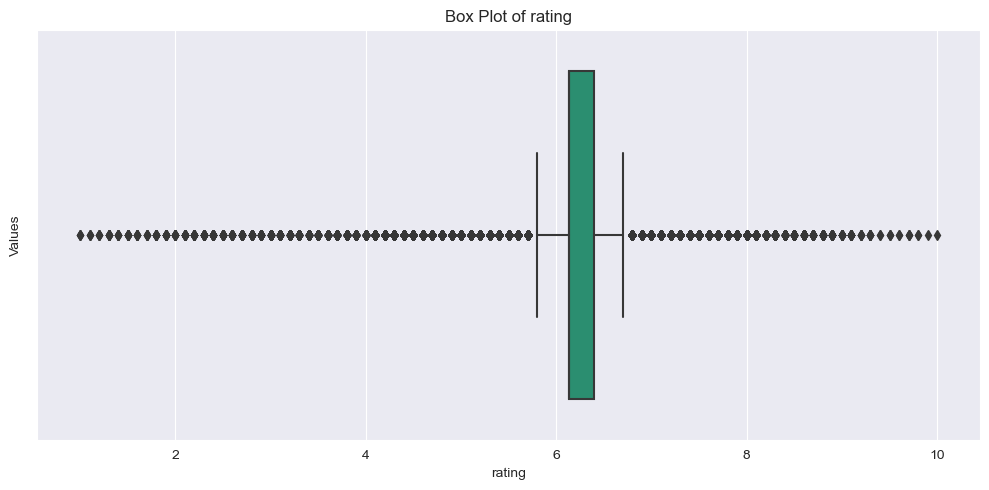

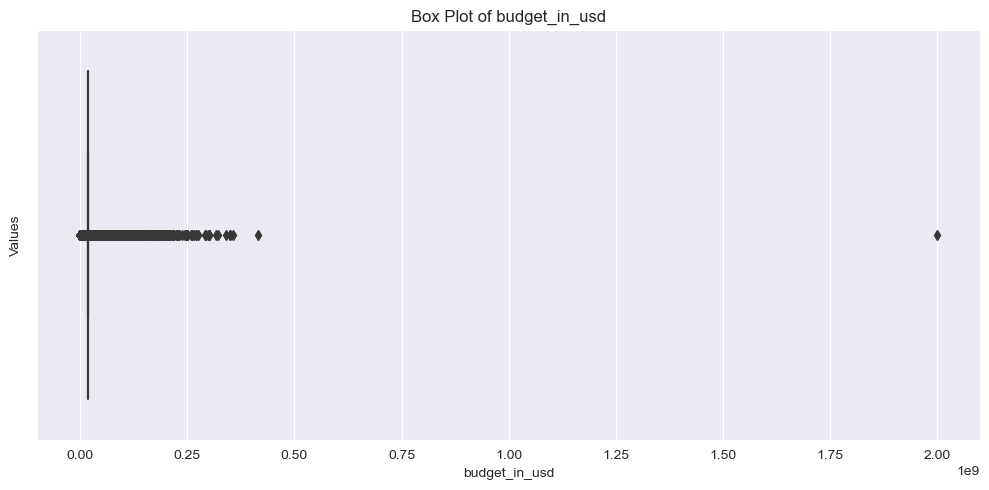

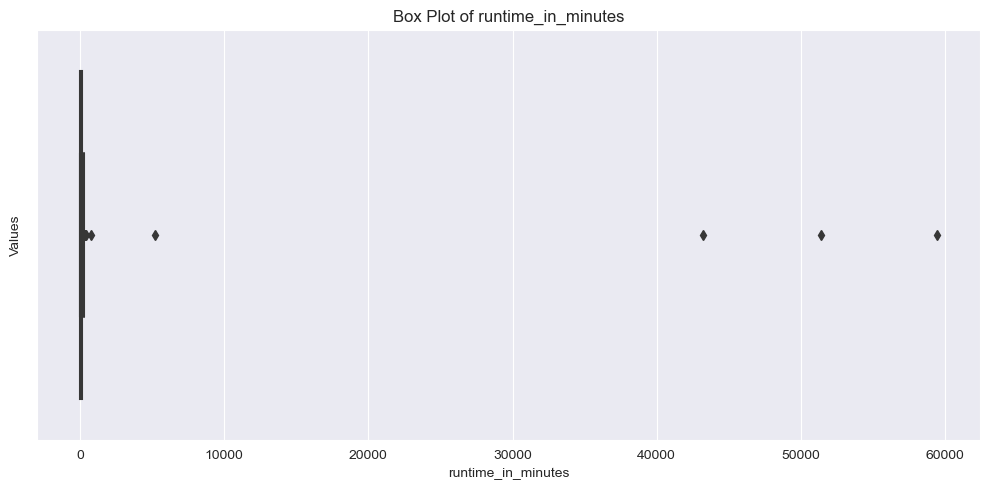

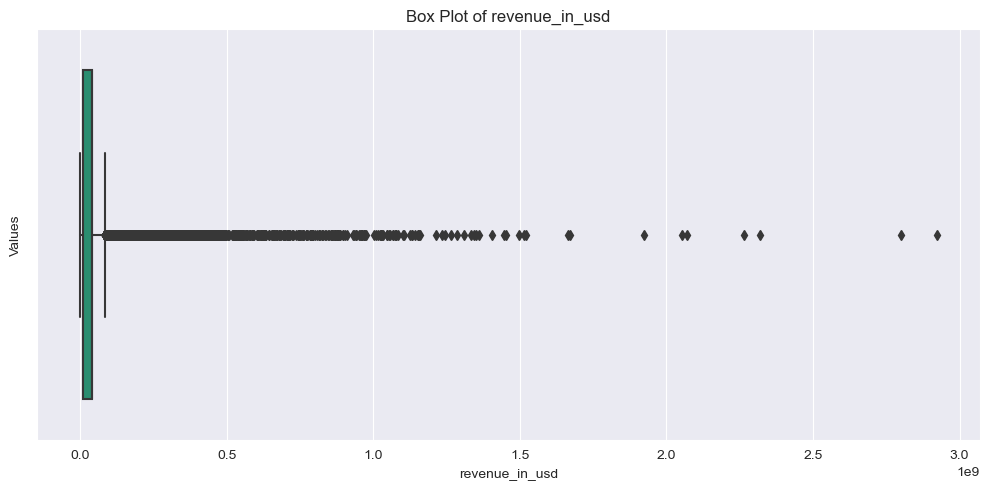

In [313]:
for column in df_not_null.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_not_null[column], palette='Dark2')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()

#### Detect with IQR

In [314]:
def outlier_count(feature):
    # Calculating IQR for current feature
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    # outlier boundaries for current feature
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr

    # finding the count of outliers for each feature
    return ((df_not_null[feature] < lower_whisker) | (df_not_null[feature] > upper_whisker)).sum()


# TODO: maybe we remove this function
def skewness(feature):
    return df_not_null[feature].skew().round(2), df_not_null[feature].hist(bins=25)

In [315]:
# for column in df_not_null.select_dtypes(include='number').columns:
#     print(f"Skewness for feature {column} is: {df_not_null[column].skew().round(2)}")
# 
# print()

for column in df_not_null.select_dtypes(include='number').columns:
    print(f"Outlier count for feature {column} is: {outlier_count(column)}")

Outlier count for feature rating is: 16421
Outlier count for feature budget_in_usd is: 13472
Outlier count for feature runtime_in_minutes is: 11
Outlier count for feature revenue_in_usd is: 2014


### 3.4.2 Applying Treatment Methods

In [483]:
class TreatmentMethods:
    def __init__(self, df):
        self.df = df

    def log_transform(self, feature):
        self.df[feature] = np.log1p(self.df[feature])
        return self.df

    def quantile_based_flooring_capping(self, feature):
        # floor = self.df[feature].quantile(0.01)
        # cap = self.df[feature].quantile(0.99)
        # self.df[feature] = np.where(self.df[feature] < floor, floor, self.df[feature])
        # self.df[feature] = np.where(self.df[feature] > cap, cap, self.df[feature])
        floor = df[feature].quantile(0.01)
        cap = df[feature].quantile(0.99)

        self.df[feature] = np.where(self.df[feature] < floor, floor, self.df[feature])
        self.df[feature] = np.where(self.df[feature] > cap, cap, self.df[feature])

        return self.df, floor, cap

    def trimming(self, feature):
        lower_bound = self.df[feature].quantile(0.05)
        upper_bound = self.df[feature].quantile(0.95)
        self.df = self.df[(self.df[feature] >= lower_bound) & (self.df[feature] <= upper_bound)]
        return self.df

In [484]:
treatment_method = TreatmentMethods(df_not_null)

#### Quantile based flooring and capping

In [316]:
df_copy_iqr = df_not_null.copy()

In [317]:
def cap_floor(feature):
    floor = df[feature].quantile(0.01)
    cap = df[feature].quantile(0.99)

    df_copy_iqr[feature] = np.where(df_copy_iqr[feature] < floor, floor, df_copy_iqr[feature])
    df_copy_iqr[feature] = np.where(df_copy_iqr[feature] > cap, cap, df_copy_iqr[feature])

    return floor, cap

In [486]:
for column in df_not_null.select_dtypes(include='number').columns:
    _, _floor, _cap = treatment_method.quantile_based_flooring_capping(column)
    print(f"Floor and Cap for the feature {column}: {_floor, _cap}")

Floor and Cap for the feature rating: (3.1, 8.3)


/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_86114/934680945.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[feature] = np.where(self.df[feature] < floor, floor, self.df[feature])
/var/folders/sb/_wglw_tj2s33qkd3sqbydk480000gn/T/ipykernel_86114/934680945.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[feature] = np.where(self.df[feature] > cap, cap, self.df[feature])


TypeError: unsupported operand type(s) for -: 'str' and 'str'

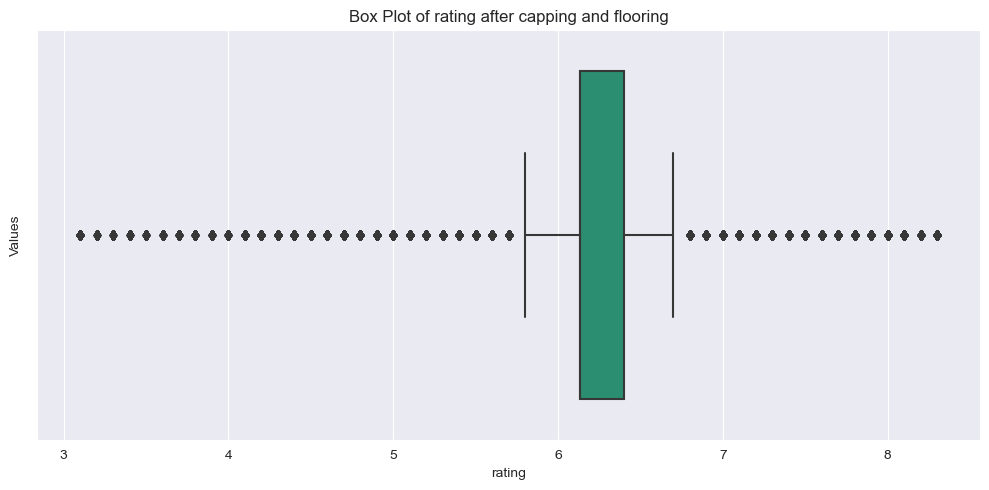

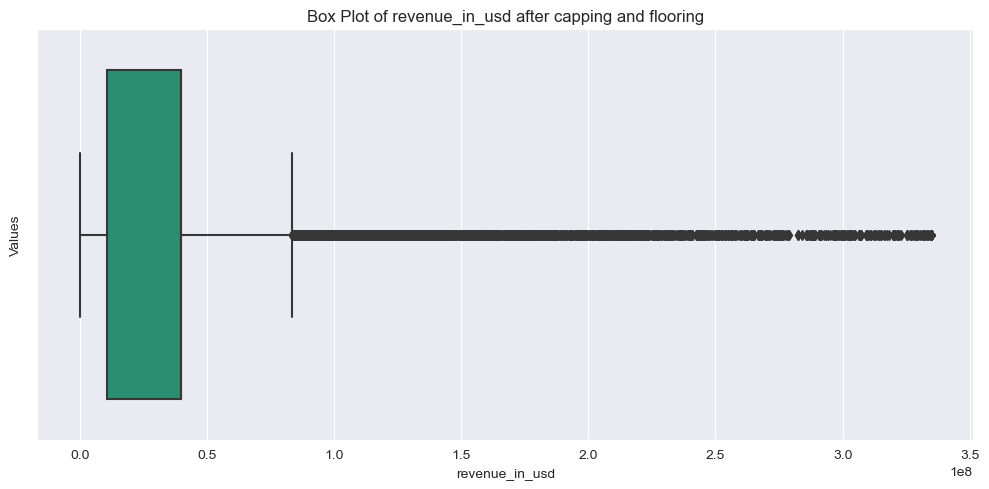

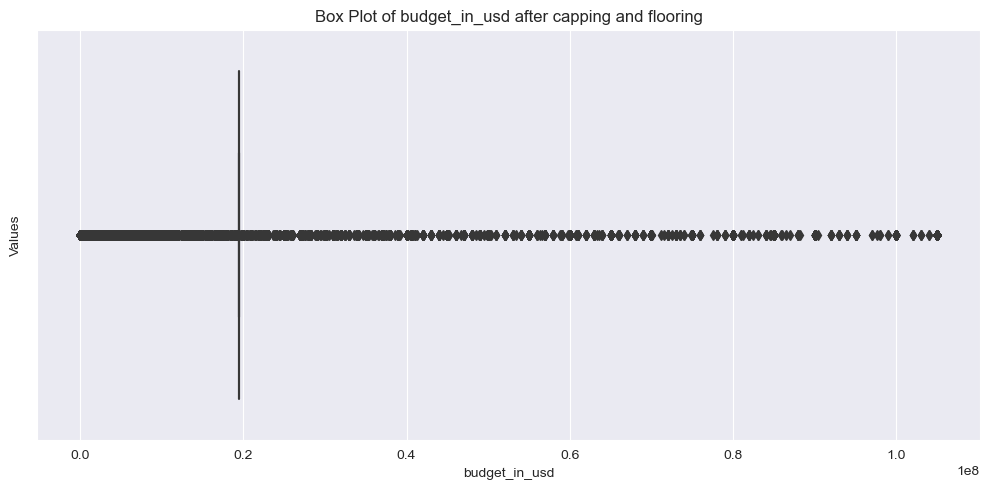

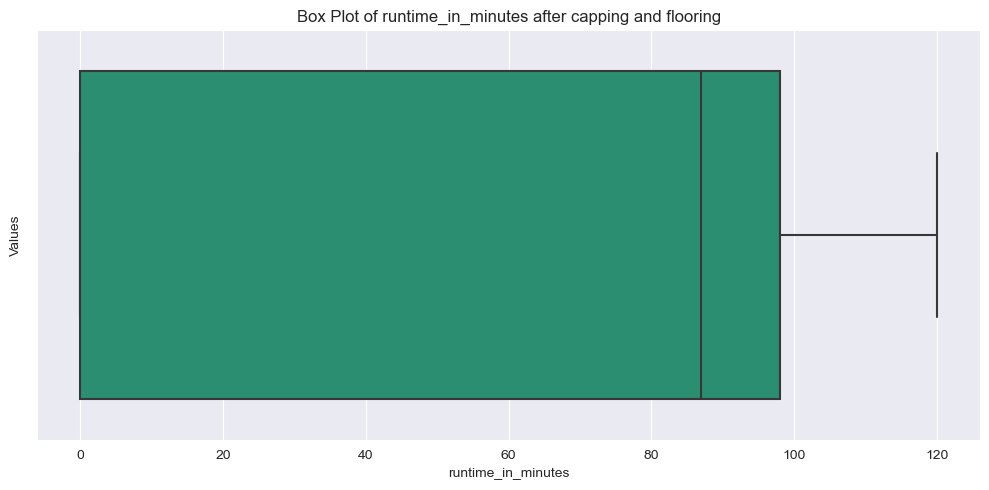

In [319]:
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df_copy_iqr[column], palette='Dark2')
    plt.title(f'Box Plot of {column} after capping and flooring')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.tight_layout()
    plt.show()

### Trimming

In [320]:
df_copy_trimming = df_not_null.copy()

In [321]:
def trimming(df, features):
    indices_to_keep = set(df.index)

    for feature in features:
        # Calculating IQR for current feature
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1

        # Outlier boundaries for current feature
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr

        # Finding indices of the rows within the whiskers
        current_indices = df[(df[feature] > lower_whisker) | (df[feature] < upper_whisker)].index
        indices_to_keep &= set(current_indices)

    return df.loc[list(indices_to_keep)]

In [322]:
print('number of records in table: ', df_copy_trimming.shape[0])

number of records in table:  46646


In [323]:
df_copy_trimming = trimming(df_not_null, df_not_null.select_dtypes(include='number').columns)

print('number of records in table: ', df_copy_trimming.shape[0])

number of records in table:  13472


#### Log Transformation

In [324]:
df_copy_log = df_not_null.copy()

In [325]:
def log_transformation(feature):
    df_copy_log[f'{feature}_log'] = df_copy_log[feature].map(lambda data: np.log(data) if data > 0 else 0)
    # min_val = df_copy_log[feature].min()
    # if min_val <= 0:
    #     df_copy_log[feature] = df_copy_log[feature] - min_val + 1
    # 
    # df_copy_log[f'{feature}_log'] = np.log(df_copy_log[feature])
    # return df

In [326]:
for column in ['budget_in_usd', 'revenue_in_usd']:
    log_transformation(column)

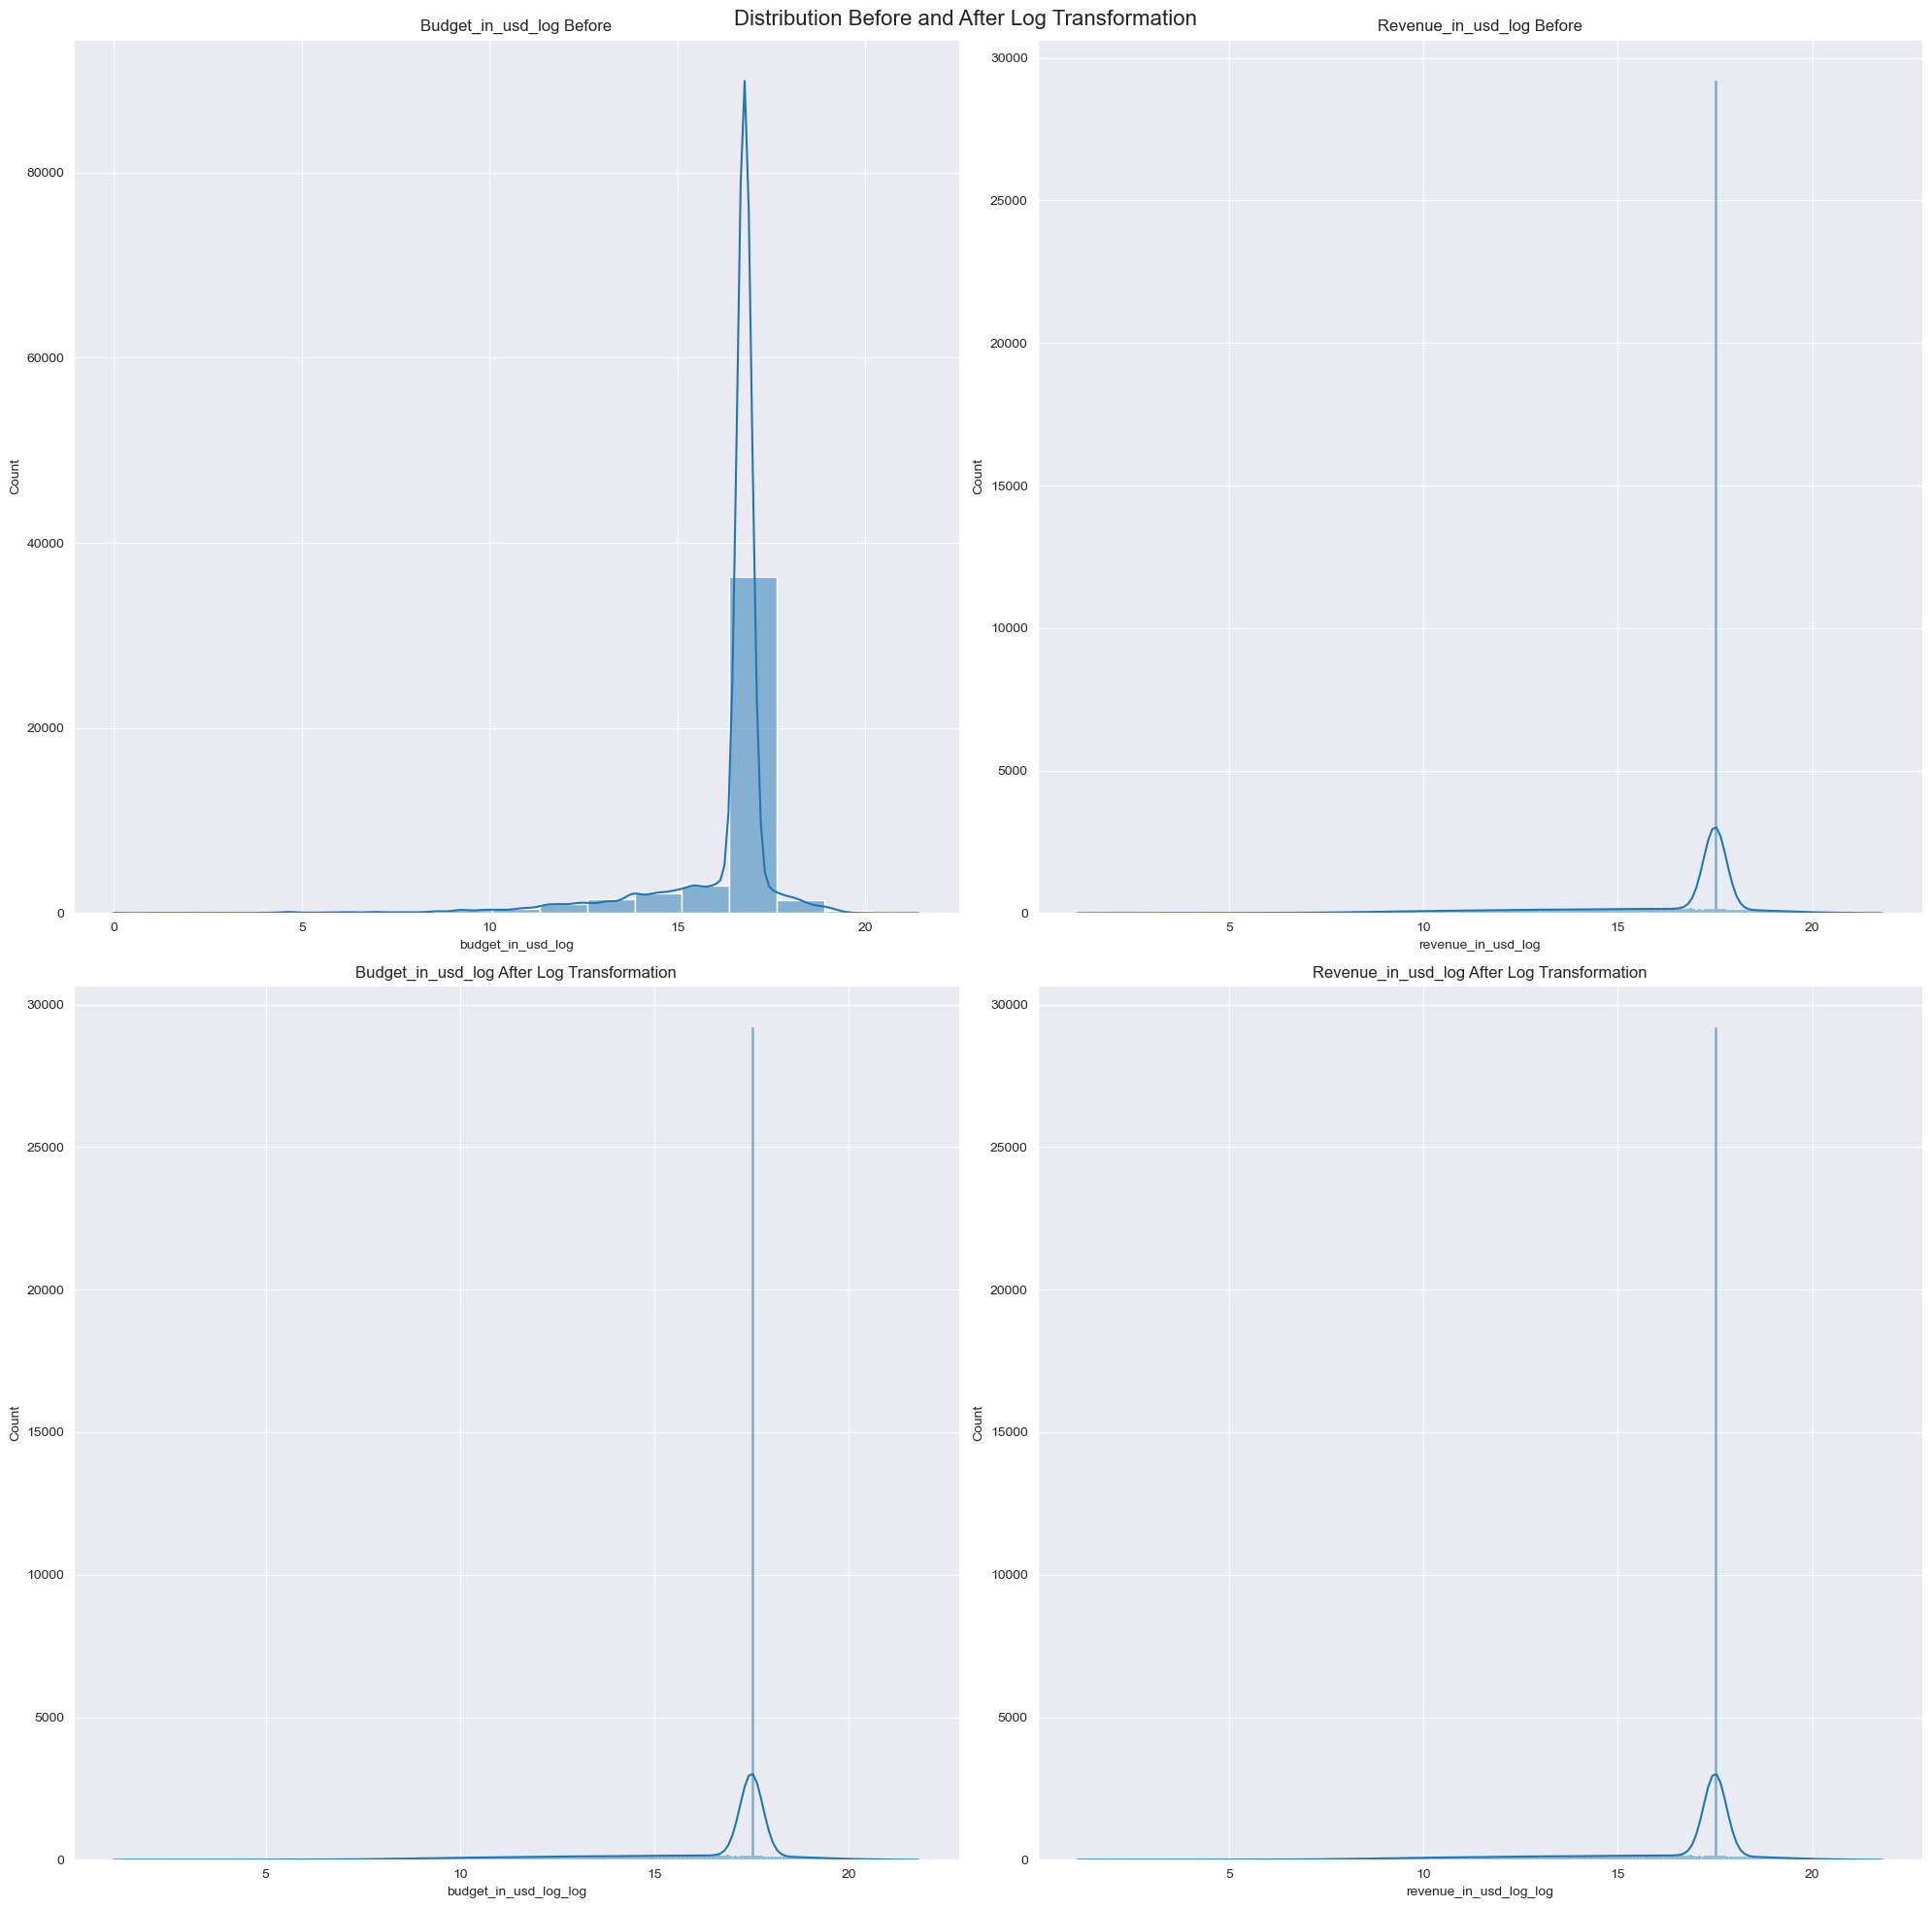

In [327]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Distribution Before and After Log Transformation', fontsize=16)

for i, col in enumerate(['budget_in_usd_log', 'revenue_in_usd_log']):
    sns.histplot(df_copy_log[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'{col.capitalize()} Before')
    axes[0, i].set_xlabel(col)

    sns.histplot(df_copy_log[f'{column}_log'], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'{col.capitalize()} After Log Transformation')
    axes[1, i].set_xlabel(f'{col}_log')

plt.tight_layout()
plt.show()

In [328]:
df_not_null.loc[:, ['budget_in_usd_log', 'revenue_in_usd_log']] \
    = df_copy_log.loc[:, ['budget_in_usd_log', 'revenue_in_usd_log']]

In [329]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
       'budget_in_usd_log', 'revenue_in_usd_log'],
      dtype='object')

In [330]:
df_copy_log['budget_in_usd_log'].tail()

46641    16.783079
46642    16.783079
46643    16.783079
46644    16.783079
46645    16.783079
Name: budget_in_usd_log, dtype: float64

# TODO:

# 3.5 Compare and discuss outcome of outlier treatments

1) decide which outlier technique will be used for the model and why

2) why will be answered by comparing the outlier treatments

4. Feature Engineering:
    - 4.1 Encode categorical variables ('Directors', 'Writers', 'Stars', 'Origin Countries', 'Languages', 'Genres' etc)
    - 4.2 Extract features from 'Storyline' using NLP techniques
    - 4.3 Create new features if applicable (e.g., director/star popularity, genre combinations) **
    - 4.4 Normalize/standardize numerical features if needed<br /><br />

### 4.1 Encode categorical variables ('Directors', 'Writers', 'Stars/Cast', 'Origin Countries', 'Languages', 'Genres' etc)

In [331]:
encoder = OrdinalEncoder()
scaler = StandardScaler()

In [384]:
df_not_null.dtypes

id                      object
title                   object
rating                 float64
storyline               object
director_team           object
writer_team             object
cast                    object
is_usa_film_market      object
language_in_english     object
budget_in_usd          float64
runtime_in_minutes     float64
revenue_in_usd         float64
main_genre              object
budget_in_usd_log      float64
revenue_in_usd_log     float64
storyline_polarity     float64
title_polarity         float64
dtype: object

In [392]:
columns_categorical = df_not_null.select_dtypes(include='category').columns
columns_categorical

Index(['director_team', 'writer_team', 'cast', 'is_usa_film_market',
       'language_in_english'],
      dtype='object')

In [394]:
df_not_null.loc[:, columns_categorical] = encoder.fit_transform(df_not_null.loc[:, columns_categorical])
df_not_null.loc[:, 'main_genre'] = encoder.fit_transform(df_not_null.loc[:, ['main_genre']])

df_not_null.head()

,id,title,rating,storyline,director_team,writer_team,cast,is_usa_film_market,language_in_english,budget_in_usd,runtime_in_minutes,revenue_in_usd,main_genre,budget_in_usd_log,revenue_in_usd_log,storyline_polarity,title_polarity
0,tt0060437,Funeral in Berlin,7.424700e-01,Sent to East Berlin to retrieve a Communist de...,2.0,2.0,0.0,0.0,2.0,0.000000,0.073154,-0.525370,19.0,0.311687,-4.425893,-0.7219,-0.3612
1,tt0098300,Shag,1.984505e-15,Summer of 1963. Carson is getting married to h...,2.0,0.0,0.0,2.0,2.0,-0.687199,0.063575,-0.433389,4.0,-0.509547,-0.225257,0.1226,0.0000
2,tt1853739,You're Next,5.190347e-01,When the Davison family comes under attack dur...,2.0,2.0,0.0,2.0,2.0,-0.877499,0.056392,-0.169819,7.0,-1.482742,0.313298,-0.8555,0.0000
3,tt22036900,Covid Karma,1.984505e-15,An Indian film maker is stuck in USA for five ...,2.0,0.0,2.0,2.0,2.0,0.000000,-0.171095,0.000000,3.0,0.311687,0.468814,-0.7650,0.0000
4,tt0419434,American Hardcore,1.984505e-15,The History of American Punk Rock 1980-1986,2.0,2.0,0.0,2.0,2.0,0.000000,0.068365,-0.520401,6.0,0.311687,-1.387513,0.0000,0.0000


### - 4.2 Extract features from 'Storyline' using NLP techniques

In [335]:
# Extract features from 'Storyline' using NLP techniques
df['storyline'] = df['storyline'].astype(str)
df['cleaned_storyline'] = (df['storyline']
                           .apply(text_wrangler.remove_digit)
                           .apply(text_wrangler.remove_punctuations)
                           .apply(text_wrangler.clean_text)
                           .apply(text_wrangler.word_lengthening)
                           .apply(text_wrangler.remove_stopwords)
                           .apply(text_wrangler.lemmatizer))

In [336]:
# TODO:

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf_storyline_features = tfidf_vectorizer.fit_transform(df['cleaned_storyline'])

# Bag of Words Vectorization
bow_vectorizer = CountVectorizer(max_features=1000)
X_bow_story_line_features = bow_vectorizer.fit_transform(df['cleaned_storyline'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf_storyline_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TODO: do the same for bag or words (Convert to DataFrame)

# TODO: Now you can use these features in your model

  # TODO: - 4.3 Create new features if applicable (e.g., director/star popularity, genre combinations) **

 #### - 4.4 Normalize/standardize numerical features if needed

In [337]:
numerical_cols.extend(['budget_in_usd_log', 'revenue_in_usd_log'])

In [338]:
df_not_null.loc[:, numerical_cols] = scaler.fit_transform(df_not_null.loc[:, numerical_cols])

In [339]:
# # Select and transform numeric columns
# df_not_null.loc[:, ['rating', 'runtime_in_minutes']] = scaler.fit_transform(
#     df_not_null[['rating', 'runtime_in_minutes']])
# 
df_not_null[['rating', 'budget_in_usd', 'revenue_in_usd', 'runtime_in_minutes', 'budget_in_usd_log',
             'revenue_in_usd_log']].describe()

,rating,budget_in_usd,revenue_in_usd,runtime_in_minutes,budget_in_usd_log,revenue_in_usd_log
count,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04,4.664600e+04
mean,1.806289e-15,4.173749e-17,-5.369513e-18,6.093065e-18,1.913755e-15,-1.171087e-15
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-5.737155e+00,-9.250737e-01,-5.253722e-01,-1.710954e-01,-9.836708e+00,-6.063331e+00
25%,1.984505e-15,0.000000e+00,-3.840661e-01,-1.710954e-01,3.116873e-01,-5.424982e-02
50%,1.984505e-15,0.000000e+00,0.000000e+00,3.723471e-02,3.116873e-01,4.688139e-01
75%,2.955993e-01,0.000000e+00,0.000000e+00,6.357530e-02,3.116873e-01,4.688139e-01
max,4.317436e+00,9.422474e+01,3.812552e+01,1.422118e+02,3.113373e+00,2.180875e+00


5. Feature Selection:
    - 5.1 Identify most important features for predicting 'Gross Worldwide' / revenue_usd
    - 5.2 Use correlation analysis or feature importance techniques<br /><br />


5.1 will be done in section 7

In [341]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
       'budget_in_usd_log', 'revenue_in_usd_log'],
      dtype='object')

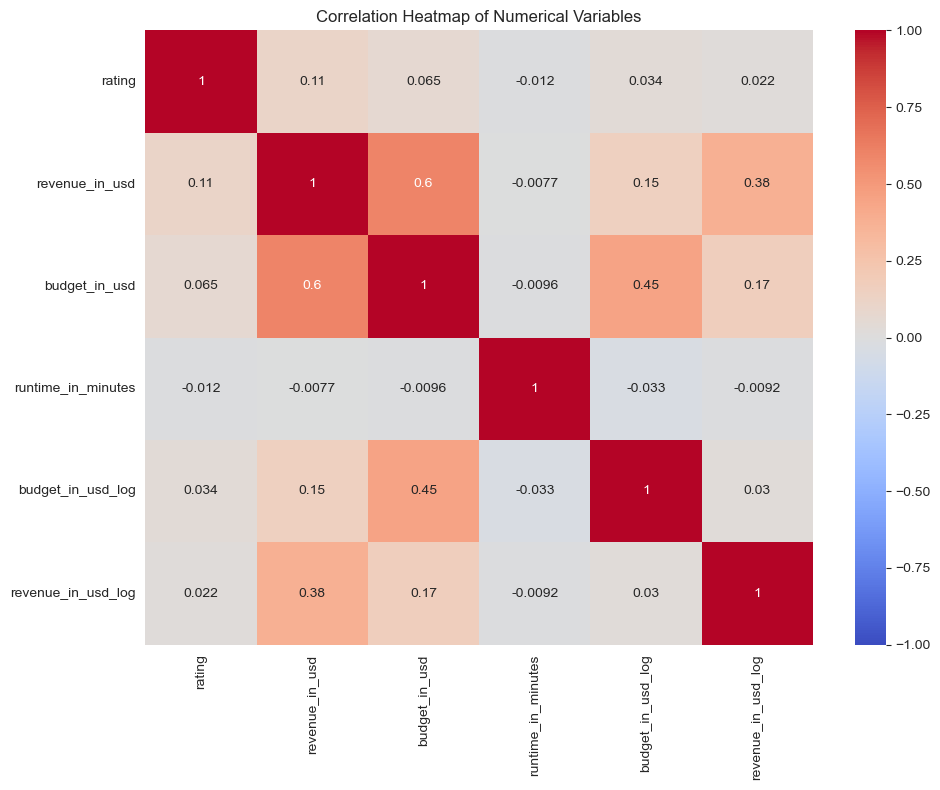

In [428]:
# correlation_matrix = df_not_null.select_dtypes(include="number").dropna().corr()
generate_correlation_heatmap(_df=df_not_null)

6. Natural Language Processing (if applicable):
    - 6.1 Text data cleaning
    - 6.2 Tokenization
    - 6.3 Stop word and punctuation removal
    - 6.4 Stemming or lemmatization<br /><br />


In [346]:
df['cleaned_storyline'].head()

0    send east berlin retrieve communist defector b...
1    summer carson get married boyfriend friend mel...
2    davison family come attack wedding anniversary...
3    indian film maker stick usa five month global ...
4                           history american punk rock
Name: cleaned_storyline, dtype: object

In [347]:
df['cleaned_title'] = (df['title']
                       .apply(str)
                       .apply(text_wrangler.remove_digit)
                       .apply(text_wrangler.remove_punctuations)
                       .apply(text_wrangler.clean_text)
                       .apply(text_wrangler.word_lengthening)
                       .apply(text_wrangler.remove_stopwords)
                       .apply(text_wrangler.lemmatizer))

In [375]:
df_not_null.loc[:, 'storyline_polarity'] = df_not_null['storyline'].apply(
    text_sentiment_analysis.get_sentiment_via_vader)
df_not_null.loc[:, 'title_polarity'] = (df_not_null['title'].apply(str).apply(
    text_sentiment_analysis.get_sentiment_via_vader))

In [ ]:
numerical_cols.extend(['storyline_polarity', 'title_polarity'])
df[numerical_cols].head()

7. Model Selection and Training:
    - 7.1 Split data into training and testing sets
    - 7.2 Select and train multiple regression models (e.g., Linear Regression, Random Forest, Gradient Boosting)
    - 7.3 Perform cross-validation<br /><br />


In [487]:
class SupervisedModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def train_model(self, model, name):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        cv_scores = cross_val_score(model, self.X, self.y, cv=5)

        return {
            'Model': name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_Scores': cv_scores,
            'CV_Mean': cv_scores.mean()
        }

    def compare_models(self):
        results = []
        models = {
            'RandomForest': RandomForestRegressor(),
            'XGBoost': XGBRegressor(objective='reg:squarederror')
        }

        for name, model in models.items():
            result = self.train_model(model, name)
            results.append(result)

        return results

In [404]:
X = df_not_null[['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market', 'language_in_english',
                 'budget_in_usd_log', 'runtime_in_minutes', 'main_genre', 'storyline_polarity', 'title_polarity']]

# using the log transformed revenue
y = df_not_null['revenue_in_usd_log']

In [430]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [431]:
# Feature Selection
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector = rf_selector.fit(X_train, y_train)
selector = SelectFromModel(rf_selector, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [432]:
# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['rating', 'budget_in_usd_log', 'runtime_in_minutes', 'storyline_polarity']


In [433]:
# Function to evaluate model
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [434]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=20, random_state=42))),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf_pipeline, param_distributions=rf_params, n_iter=100, cv=5, random_state=42,
                               n_jobs=-1)
rf_random.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_random.best_params_)
rf_results = evaluate_model(rf_random.best_estimator_, X_test, y_test)
print("Random Forest results:", rf_results)

/Users/mac/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 10}
Random Forest results: {'MSE': 0.8948804686448825, 'RMSE': 0.9459812200275872, 'MAE': 0.6717095888901937, 'R2': 0.09692821499607784}


In [435]:
# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(XGBRegressor(n_estimators=100, random_state=42))),
    ('regressor', XGBRegressor(random_state=42))
])

xgb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.7, 0.8, 0.9]
}

xgb_random = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=xgb_params, n_iter=100, cv=5,
                                random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_random.best_params_)
xgb_results = evaluate_model(xgb_random.best_estimator_, X_test, y_test)
print("XGBoost results:", xgb_results)

Best XGBoost parameters: {'regressor__subsample': 0.9, 'regressor__n_estimators': 100, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
XGBoost results: {'MSE': 0.9161435616752742, 'RMSE': 0.9571538860994475, 'MAE': 0.6878675239714015, 'R2': 0.07547048957858382}


In [436]:
# Cross-validation scores
rf_cv_scores = cross_val_score(rf_random.best_estimator_, X_train_selected, y_train, cv=5, scoring='r2')
xgb_cv_scores = cross_val_score(xgb_random.best_estimator_, X_train_selected, y_train, cv=5, scoring='r2')

print("Random Forest CV scores:", rf_cv_scores)
print("XGBoost CV scores:", xgb_cv_scores)

Random Forest CV scores: [ 0.00043781  0.00146646 -0.00122937  0.00149837 -0.00230011]
XGBoost CV scores: [0.07817824 0.07521631 0.05558077 0.06230229 0.08379917]


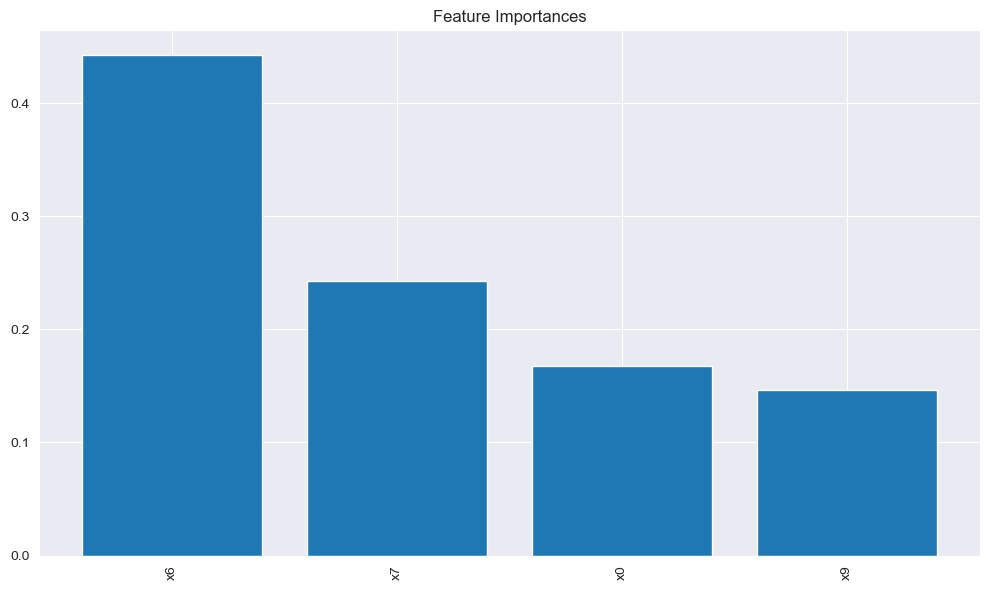

In [437]:
# Feature importance plot
feature_importance = rf_random.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = rf_random.best_estimator_.named_steps['feature_selection'].get_feature_names_out()

plt.figure(figsize=(10, 6))
indices = np.argsort(feature_importance)[::-1]
plt.title("Feature Importances")
plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

#### Model Performance:
Both Random Forest and XGBoost models are performing poorly, with very low R-squared values (0.0990 for Random Forest and 0.0780 for XGBoost). 
This indicates that the models are explaining less than 10% of the variance in the target variable (revenue).

#### Comparison:
Random Forest slightly outperforms XGBoost, but the difference is minimal. Both models are struggling to predict revenue accurately.

#### Error Metrics:
The RMSE and MAE values are quite high relative to what we'd expect for log-transformed revenue. This suggests large prediction errors.

#### Cross-Validation Scores:
The Random Forest CV scores are extremely low and even negative, indicating that the model is performing worse than a horizontal line (mean prediction).
XGBoost CV scores are slightly better but still very low, ranging from about 0.06 to 0.09.

#### Consistency:
XGBoost shows more consistency across folds in cross-validation, while Random Forest scores are more volatile and consistently poor.

In [456]:
# df_not_null['genre_count'].head()

0    1.0
1    3.0
2    3.0
3    2.0
4    3.0
Name: genre_count, dtype: float64

In [465]:
# Feature Engineering
df_not_null.loc[:, 'budget_to_runtime_ratio'] = df_not_null.loc[:, 'budget_in_usd_log'] / df_not_null.loc[:,
                                                                                          'runtime_in_minutes']
df_not_null.loc[:, 'is_english'] = df.loc[:, 'language_in_english'].apply(str).apply(lambda x: 1 if 'yes' in x else 0)
df_not_null.loc[:, 'genre_count'] = df.loc[:, 'genres'].str.count(',') + 1
df_not_null.loc[:, 'genre_count'] = df_not_null.loc[:, 'genre_count'].fillna(0).astype(int)

# Prepare the data
X = df_not_null[['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market', 'language_in_english',
                 'budget_in_usd_log', 'runtime_in_minutes', 'main_genre', 'storyline_polarity', 'title_polarity',
                 'budget_to_runtime_ratio', 'is_english', 'genre_count']]
y = df_not_null['revenue_in_usd_log']


In [467]:
df_not_null['genre_count'].isnull().sum()

0

In [473]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Function to evaluate model
def evaluate_model(model, X, y, y_original):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    # If we used log transformation, we need to transform back for interpretability
    if np.array_equal(y, y_original):
        revenue_mape = np.mean(np.abs((np.exp(y) - np.exp(predictions)) / np.exp(y))) * 100
    else:
        revenue_mape = np.mean(np.abs((y - predictions) / y)) * 100

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Revenue_MAPE': revenue_mape}


In [479]:
# List of models to try
models = [
    # ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    # ('Elastic Net', ElasticNet(random_state=42)),
    # ('Neural Network', MLPRegressor(random_state=42, max_iter=1000))
]

# using both log-transformed and original revenue
for target, y_train_data, y_test_data in [('Log Revenue', y_train, y_test),
                                          ('Original Revenue', np.exp(y_train), np.exp(y_test))]:
    print(f"\nResults for {target}:")

    for name, model in models:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])

        # Set up parameter grid for each model
        if name == 'Random Forest':
            param_grid = {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [10, 20, 30, None],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        elif name == 'XGBoost':
            param_grid = {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [3, 4, 5, 6],
                'regressor__learning_rate': [0.01, 0.1, 0.3],
                'regressor__subsample': [0.7, 0.8, 0.9],
                'regressor__reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
                'regressor__reg_lambda': [0, 0.1, 0.5, 1]  # L2 regularization
            }
        elif name == 'Gradient Boosting':
            param_grid = {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [3, 4, 5, 6],
                'regressor__learning_rate': [0.01, 0.1, 0.3],
                'regressor__subsample': [0.7, 0.8, 0.9]
            }
        elif name == 'Elastic Net':
            param_grid = {
                'regressor__alpha': [0.1, 0.5, 1, 2, 5],
                'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        else:  # Neural Network
            param_grid = {
                'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'regressor__alpha': [0.0001, 0.001, 0.01, 0.1]
            }

        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                           n_iter=50, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train_data)

        # Evaluate the model
        results = evaluate_model(random_search.best_estimator_, X_test, y_test_data, y_test)
        print(f"\n{name} results:")
        print(f"Best parameters: {random_search.best_params_}")
        for metric, value in results.items():
            print(f"{metric}: {value}")

        # Perform cross-validation
        cv_scores = cross_val_score(random_search.best_estimator_, X_train, y_train_data, cv=5, scoring='r2')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV score: {np.mean(cv_scores)}")



Results for Log Revenue:


KeyboardInterrupt: 

In [478]:
# Feature Importance for the best performing model (assuming it's tree-based)
best_model = random_search.best_estimator_
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    feature_importance = best_model.named_steps['regressor'].feature_importances_
    feature_names = X.columns

    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1]
    plt.title("Feature Importances")
    plt.bar(range(len(feature_importance)), feature_importance[indices])
    plt.xticks(range(len(feature_importance)), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()

8. Results and Visualization (based on regression models):
    - 8.1 Create meaningful visualizations of your findings (e.g., actual vs predicted revenues)
    - 8.2 Interpret and explain results<br /><br />


9. Unsupervised Learning:
    - 9.1 Select and apply two unsupervised learning methods
    - 9.2 Analyze and interpret results
    - 9.3 Compare outcomes of different methods
    - 9.4 Create a feature from this cluster generated and put it into the regression model 
    - 9.5 Analyse the result from the new feature you engineered    <br /><br />


In [491]:



class UnsupervisedLearning:
    def __init__(self, X):
        self.X = X

    def apply_pca(self, n_components=2):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(X_scaled)
        return principal_components

    def apply_kmeans(self, n_clusters=3):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(self.X)
        clusters = kmeans.labels_
        return clusters

    def add_cluster_feature(self, clusters):
        X_copy = self.X.copy()
        X_copy['cluster'] = clusters
        return X_copy

In [492]:
# Unsupervised Learning
unsupervised_learning = UnsupervisedLearning(X)

# Apply PCA
pca_components = unsupervised_learning.apply_pca()
print("PCA Components:", pca_components)

# Apply K-means
clusters = unsupervised_learning.apply_kmeans()
print("K-means Clusters:", clusters)

PCA Components: [[-0.94178595  1.23103507]
 [-1.35249859 -0.39216523]
 [-1.77102556 -0.77324291]
 ...
 [ 1.71328775  0.16909034]
 [-1.10573706  1.01242446]
 [ 2.55987454  0.12406417]]


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means Clusters: [0 0 0 ... 0 0 0]


In [510]:
df_not_null.columns

Index(['id', 'title', 'rating', 'storyline', 'director_team', 'writer_team',
       'cast', 'is_usa_film_market', 'language_in_english', 'budget_in_usd',
       'runtime_in_minutes', 'revenue_in_usd', 'main_genre',
       'budget_in_usd_log', 'revenue_in_usd_log', 'storyline_polarity',
       'title_polarity', 'budget_to_runtime_ratio', 'is_english',
       'genre_count'],
      dtype='object')

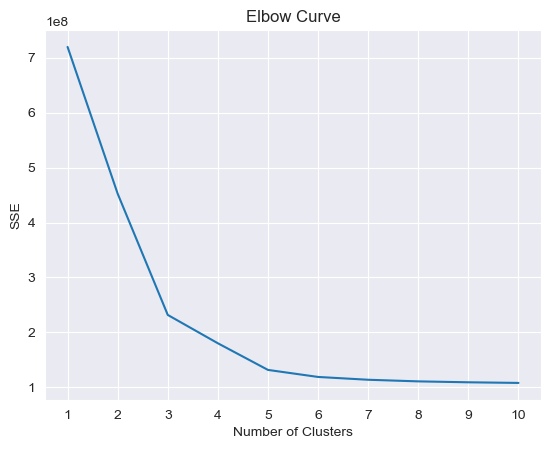

In [516]:
# KMeans Clustering
from sklearn.cluster import KMeans

# standardize the entire data
movie_df = X
movie_df.loc[:, 'revenue_in_usd'] = df_not_null.loc[:, 'revenue_in_usd']
movie_df.loc[:, 'budget_in_usd'] = df_not_null.loc[:, 'budget_in_usd']
movie_df.loc[:, 'revenue_in_usd_log'] = df_not_null.loc[:, 'revenue_in_usd_log']

# determine number of clusters using the elbow method

# initialize kmeans parameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 42,
    "max_iter": 300
}

range_value = range(1, 11)

# create list to hold SSE values for each k
sse = []
for k in range_value:
    k_means = KMeans(n_clusters=k, **kmeans_kwargs)
    k_means.fit(movie_df)
    sse.append(k_means.inertia_)

# visualize results
plt.plot(range_value, sse)
plt.xticks(range_value)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Curve")
plt.show()

In [517]:
from kneed import KneeLocator

# determine number of clusters
kl = KneeLocator(range_value, sse, curve="convex", direction="decreasing")

# call the function
kl.elbow

3

In [518]:
movie_df.columns

Index(['rating', 'director_team', 'writer_team', 'cast', 'is_usa_film_market',
       'language_in_english', 'budget_in_usd_log', 'runtime_in_minutes',
       'main_genre', 'storyline_polarity', 'title_polarity',
       'budget_to_runtime_ratio', 'is_english', 'genre_count',
       'revenue_in_usd_log', 'kmeans_cluster', 'revenue_in_usd',
       'budget_in_usd'],
      dtype='object')

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


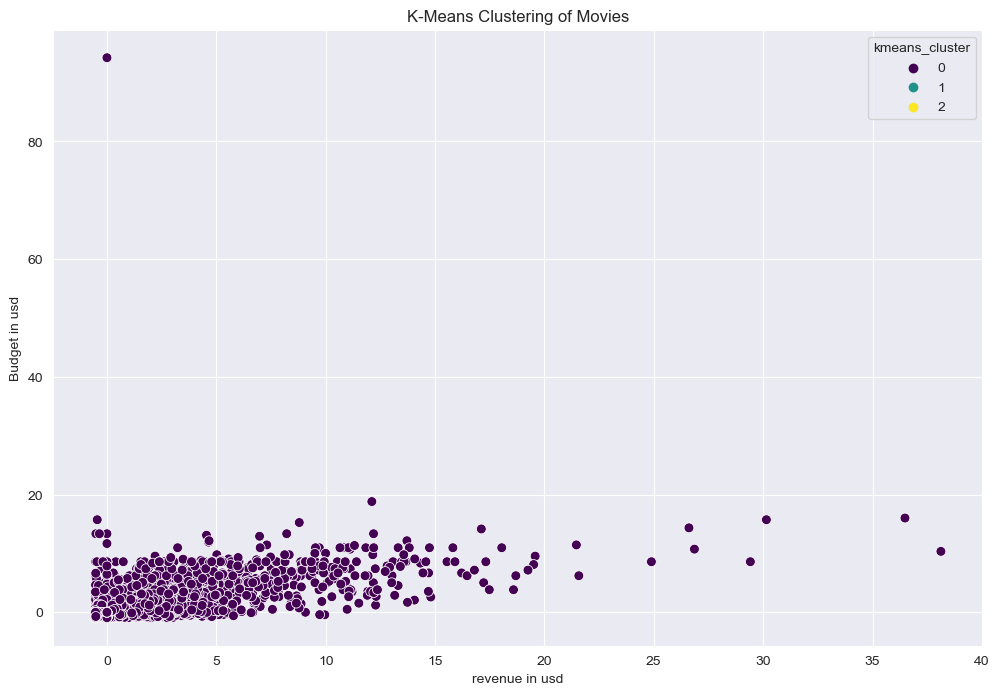

In [519]:
# Example using the optimal K from elbow method (adjust as per your elbow plot)
optimal_k = 3

# Initialize KMeans with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X)

# Add cluster labels to the dataframe
movie_df.loc[:, 'kmeans_cluster'] = kmeans_clusters

# Example scatter plot of clusters (adjust features as needed)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='revenue_in_usd', y='budget_in_usd', hue='kmeans_cluster', data=movie_df, palette='viridis', s=50)
plt.title('K-Means Clustering of Movies')
plt.xlabel('revenue in usd')
plt.ylabel('Budget in usd')
plt.show()

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


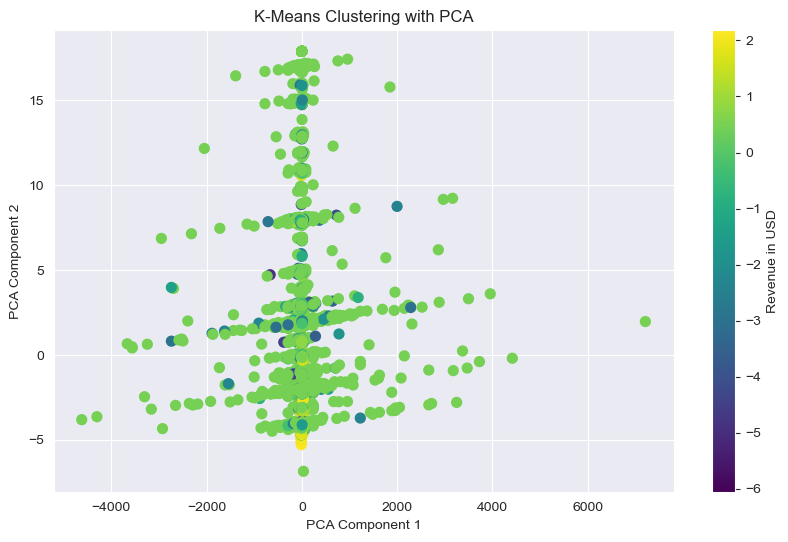

In [520]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA
pca = PCA(n_components=2)  # Using 2 components for visualization
X_pca = pca.fit_transform(movie_df)

# Train K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_pca_kmeans = kmeans.fit_predict(X_pca)

# Plot the clusters with revenue_in_USD as color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.title('K-Means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Revenue in USD')
plt.show()


In [521]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
transformed_x = pca.fit_transform(X)

In [522]:
k_means_pca_df = pd.DataFrame(
    np.hstack((transformed_x, k_means.labels_.reshape(-1, 1))),
    columns=[
        "pca1", "pca2", "pca3", "pca4", "pca5", "pca6",
        "pca7", "pca8", "pca9", "pca10", "clusters"
    ]
)

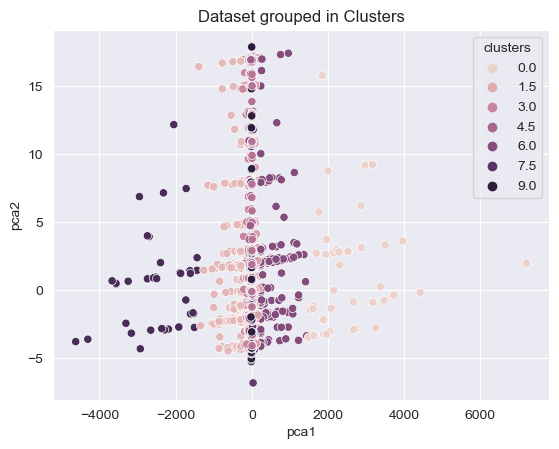

In [523]:
# K Means classes
sns.scatterplot(x="pca1", y="pca2", hue='clusters', data=k_means_pca_df)
plt.plot()
plt.title("Dataset grouped in Clusters")
plt.show()

10. Results and Visualization (based on unsupervised learning):
    - 10.1 Create meaningful visualizations of your findings (e.g., actual vs predicted revenues)
    - 10.2 Interpret and explain results<br /><br />


11. Conclusion and Recommendations:
    - 11.1 Summarize key findings
    - 11.2 Discuss the most influential factors for movie revenue
    - 11.3 Provide actionable insights or recommendations<br /><br />